In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from alphamind.api import *
from PyFin.api import *
from PyFin.Math.Accumulators.StatefulAccumulators import MovingAverage
from PyFin.Math.Accumulators.StatefulAccumulators import MovingSharp
from PyFin.Math.Accumulators.StatefulAccumulators import MovingMaxDrawdown

plt.style.use('ggplot')

In [2]:
"""
Back test parameter settings
"""

start_date = '2012-01-01'
end_date = '2018-01-02'
benchmark_code = 300
universe_name = ['zz500', 'hs300']
universe = Universe(universe_name, universe_name)
frequency = '5b'
batch = 16
method = 'risk_neutral'
use_rank = 100
industry_lower = 1.
industry_upper = 1.
neutralize_risk = ['SIZE', 'LEVERAGE'] + industry_styles
constraint_risk = ['SIZE', 'LEVERAGE'] + industry_styles
size_risk_lower = 0
size_risk_upper = 0
turn_over_target_base = 0.25
benchmark_total_lower = 0.8
benchmark_total_upper = 1.
horizon = map_freq(frequency)
hedging_ratio = 0.

executor = NaiveExecutor()

In [3]:
"""
Model phase: we need 1 constant linear model and one alpha model
"""

const_features_keys = ['roe_q_raw',
                       'ep_q_raw',
                       'DivP_raw',
                       'cfinc1_q_raw',
                       'EBIT_raw',
                       'EARNYILD_raw',
                       'EPIBS_raw']

const_weights = [0.2,
                 0.2,
                 0.1,
                 0.15,
                 0.10,
                 0.10,
                 0.10]

const_weights = pd.Series(const_weights,
                          index=const_features_keys)

const_model = ConstLinearModel(features=const_features_keys,
                               weights=const_weights)

linear_model_features = {
    'ep_q_raw': LAST('ep_q'),
    'roe_q_raw': LAST('roe_q'),
    'DivP_raw': LAST('DivP'),
    'cfinc1_q_raw': LAST('cfinc1_q'),
    'EBIT_raw': LAST('EBIT'),
    'EARNYILD_raw': LAST('EARNYILD'),
    'EPIBS_raw': LAST('EPIBS')
}

total_features = {
    'IVR_raw': LAST('IVR'),
    'DivP_raw': LAST('DivP'),
    'cfinc1_q_raw': LAST('cfinc1_q'),
    'CFinc1_raw': LAST('CFinc1'),
    'roe_q_raw': LAST('roe_q'),
    'ep_q_raw': LAST('ep_q'),
    'EBIT_raw': LAST('EBIT'),
    'EARNYILD_raw': LAST('EARNYILD'),
    'EPIBS_raw': LAST('EPIBS')
}

total_features_keys = list(total_features.keys())

In [8]:
"""
Data phase
"""

engine = SqlEngine()

linear_model_factor_data = fetch_data_package(engine,
                                              alpha_factors=linear_model_features,
                                              start_date=start_date,
                                              end_date=end_date,
                                              frequency=frequency,
                                              universe=universe,
                                              benchmark=benchmark_code,
                                              batch=batch,
                                              neutralized_risk=neutralize_risk,
                                              pre_process=[winsorize_normal, standardize],
                                              post_process=[winsorize_normal, standardize],
                                              warm_start=batch)

linear_model_features_keys = linear_model_factor_data['x_names']

train_x = linear_model_factor_data['train']['x']
train_y = linear_model_factor_data['train']['y']
train_risk = linear_model_factor_data['train']['risk']
ref_dates = sorted(train_x.keys())

predict_x = linear_model_factor_data['predict']['x']
predict_y = linear_model_factor_data['predict']['y']
predict_risk = linear_model_factor_data['predict']['risk']
predict_code = linear_model_factor_data['predict']['code']
settlement = linear_model_factor_data['settlement']


2018-01-08 18:07:19,841 - ALPHA_MIND - INFO - Starting data package fetching ...
2018-01-08 18:07:45,968 - ALPHA_MIND - INFO - factor data loading finished
2018-01-08 18:07:56,680 - ALPHA_MIND - INFO - return data loading finished
2018-01-08 18:07:58,390 - ALPHA_MIND - INFO - industry data loading finished
2018-01-08 18:07:58,843 - ALPHA_MIND - INFO - benchmark data loading finished
2018-01-08 18:08:10,650 - ALPHA_MIND - INFO - risk data loading finished
2018-01-08 18:08:13,305 - ALPHA_MIND - INFO - data merging finished
2018-01-08 18:08:15,133 - ALPHA_MIND - INFO - Loading data is finished
2018-01-08 18:08:24,804 - ALPHA_MIND - INFO - Data processing is finished


In [9]:
def cross_product(x, y):
    n, m = x.shape
    res = []
    
    for j in range(m):
        res.append(x[:, [j]] * y)
        
    return np.concatenate(res, axis=1)

In [11]:
"""
Training phase
"""

models_series = pd.Series()

for ref_date in ref_dates:
    x = train_x[ref_date]
    y = train_y[ref_date]
    risk = train_risk[ref_date][:, 1:]
    new_x = cross_product(x, risk)

    model = LinearRegression(features=linear_model_features_keys, fit_intercept=True) # n_jobs=8, min_samples_split=20)
    model = LassoRegression(alpha=0.01, features=linear_model_features_keys, fit_intercept=True) # n_jobs=8, min_samples_split=20)
    model.fit(new_x, y)
    models_series.loc[ref_date] = model
    alpha_logger.info('trade_date: {0} training finished'.format(ref_date))


frequency = '5b'
ref_dates = makeSchedule(start_date, end_date, frequency, 'china.sse')

const_model_factor_data = engine.fetch_data_range(universe,
                                                  total_features,
                                                  dates=ref_dates,
                                                  benchmark=benchmark_code)['factor']

horizon = map_freq(frequency)

2018-01-08 18:08:52,953 - ALPHA_MIND - INFO - trade_date: 2012-02-15 00:00:00 training finished
2018-01-08 18:08:53,104 - ALPHA_MIND - INFO - trade_date: 2012-02-22 00:00:00 training finished
2018-01-08 18:08:53,255 - ALPHA_MIND - INFO - trade_date: 2012-02-29 00:00:00 training finished
2018-01-08 18:08:53,414 - ALPHA_MIND - INFO - trade_date: 2012-03-07 00:00:00 training finished
2018-01-08 18:08:53,499 - ALPHA_MIND - INFO - trade_date: 2012-03-14 00:00:00 training finished
2018-01-08 18:08:53,608 - ALPHA_MIND - INFO - trade_date: 2012-03-21 00:00:00 training finished
2018-01-08 18:08:53,717 - ALPHA_MIND - INFO - trade_date: 2012-03-28 00:00:00 training finished
2018-01-08 18:08:53,819 - ALPHA_MIND - INFO - trade_date: 2012-04-09 00:00:00 training finished
2018-01-08 18:08:53,912 - ALPHA_MIND - INFO - trade_date: 2012-04-16 00:00:00 training finished
2018-01-08 18:08:53,994 - ALPHA_MIND - INFO - trade_date: 2012-04-23 00:00:00 training finished
2018-01-08 18:08:54,059 - ALPHA_MIND - I

2018-01-08 18:09:01,262 - ALPHA_MIND - INFO - trade_date: 2013-11-26 00:00:00 training finished
2018-01-08 18:09:01,329 - ALPHA_MIND - INFO - trade_date: 2013-12-03 00:00:00 training finished
2018-01-08 18:09:01,396 - ALPHA_MIND - INFO - trade_date: 2013-12-10 00:00:00 training finished
2018-01-08 18:09:01,462 - ALPHA_MIND - INFO - trade_date: 2013-12-17 00:00:00 training finished
2018-01-08 18:09:01,537 - ALPHA_MIND - INFO - trade_date: 2013-12-24 00:00:00 training finished
2018-01-08 18:09:01,650 - ALPHA_MIND - INFO - trade_date: 2013-12-31 00:00:00 training finished
2018-01-08 18:09:01,756 - ALPHA_MIND - INFO - trade_date: 2014-01-08 00:00:00 training finished
2018-01-08 18:09:01,873 - ALPHA_MIND - INFO - trade_date: 2014-01-15 00:00:00 training finished
2018-01-08 18:09:01,987 - ALPHA_MIND - INFO - trade_date: 2014-01-22 00:00:00 training finished
2018-01-08 18:09:02,116 - ALPHA_MIND - INFO - trade_date: 2014-01-29 00:00:00 training finished
2018-01-08 18:09:02,281 - ALPHA_MIND - I

2018-01-08 18:09:10,099 - ALPHA_MIND - INFO - trade_date: 2015-08-26 00:00:00 training finished
2018-01-08 18:09:10,180 - ALPHA_MIND - INFO - trade_date: 2015-09-02 00:00:00 training finished
2018-01-08 18:09:10,258 - ALPHA_MIND - INFO - trade_date: 2015-09-11 00:00:00 training finished
2018-01-08 18:09:10,339 - ALPHA_MIND - INFO - trade_date: 2015-09-18 00:00:00 training finished
2018-01-08 18:09:10,441 - ALPHA_MIND - INFO - trade_date: 2015-09-25 00:00:00 training finished
2018-01-08 18:09:10,541 - ALPHA_MIND - INFO - trade_date: 2015-10-09 00:00:00 training finished
2018-01-08 18:09:10,623 - ALPHA_MIND - INFO - trade_date: 2015-10-16 00:00:00 training finished
2018-01-08 18:09:10,697 - ALPHA_MIND - INFO - trade_date: 2015-10-23 00:00:00 training finished
2018-01-08 18:09:10,760 - ALPHA_MIND - INFO - trade_date: 2015-10-30 00:00:00 training finished
2018-01-08 18:09:10,840 - ALPHA_MIND - INFO - trade_date: 2015-11-06 00:00:00 training finished
2018-01-08 18:09:10,969 - ALPHA_MIND - I

2018-01-08 18:09:18,588 - ALPHA_MIND - INFO - trade_date: 2017-06-07 00:00:00 training finished
2018-01-08 18:09:18,680 - ALPHA_MIND - INFO - trade_date: 2017-06-14 00:00:00 training finished
2018-01-08 18:09:18,783 - ALPHA_MIND - INFO - trade_date: 2017-06-21 00:00:00 training finished
2018-01-08 18:09:18,876 - ALPHA_MIND - INFO - trade_date: 2017-06-28 00:00:00 training finished
2018-01-08 18:09:18,957 - ALPHA_MIND - INFO - trade_date: 2017-07-05 00:00:00 training finished
2018-01-08 18:09:19,040 - ALPHA_MIND - INFO - trade_date: 2017-07-12 00:00:00 training finished
2018-01-08 18:09:19,154 - ALPHA_MIND - INFO - trade_date: 2017-07-19 00:00:00 training finished
2018-01-08 18:09:19,254 - ALPHA_MIND - INFO - trade_date: 2017-07-26 00:00:00 training finished
2018-01-08 18:09:19,370 - ALPHA_MIND - INFO - trade_date: 2017-08-02 00:00:00 training finished
2018-01-08 18:09:19,476 - ALPHA_MIND - INFO - trade_date: 2017-08-09 00:00:00 training finished
2018-01-08 18:09:19,572 - ALPHA_MIND - I

2018-01-08 18:11:01,091 - ALPHA_MIND - INFO - 2012-01-04 00:00:00: 800


start 0.01 weight gap simulation ...


2018-01-08 18:11:01,097 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:11:01,103 - ALPHA_MIND - INFO - 2012-01-11 00:00:00: 800
2018-01-08 18:11:01,107 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:11:01,116 - ALPHA_MIND - INFO - 2012-01-18 00:00:00: 800
2018-01-08 18:11:01,122 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:11:01,128 - ALPHA_MIND - INFO - 2012-02-01 00:00:00: 800
2018-01-08 18:11:01,137 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:11:01,144 - ALPHA_MIND - INFO - 2012-02-08 00:00:00: 800
2018-01-08 18:11:01,149 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:11:01,157 - ALPHA_MIND - INFO - 2012-02-15 00:00:00: 800
2018-01-08 18:11:01,312 - ALPHA_MIND - INFO - 2012-02-15 00:00:00 is finished
2018-01-08 18:11:01,321 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:11:01,589 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-08 18:11:01,595 - ALPHA_MIND - INFO - 2012-02-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:01,857 - ALPHA_MIND - INFO - 2012-02-29 00:00:00 is finished
2018-01-08 18:11:01,865 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:11:02,224 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-08 18:11:02,231 - ALPHA_MIND - INFO - 2012-03-14 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:11:02,583 - ALPHA_MIND - INFO - 2012-03-14 00:00:00 is finished
2018-01-08 18:11:02,595 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798


using backbone model and alpha model


2018-01-08 18:11:02,942 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-08 18:11:02,952 - ALPHA_MIND - INFO - 2012-03-28 00:00:00: 798


using backbone model and alpha model


2018-01-08 18:11:03,273 - ALPHA_MIND - INFO - 2012-03-28 00:00:00 is finished
2018-01-08 18:11:03,280 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:03,605 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-08 18:11:03,615 - ALPHA_MIND - INFO - 2012-04-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:03,886 - ALPHA_MIND - INFO - 2012-04-16 00:00:00 is finished
2018-01-08 18:11:03,892 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:04,142 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-08 18:11:04,147 - ALPHA_MIND - INFO - 2012-05-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:04,376 - ALPHA_MIND - INFO - 2012-05-02 00:00:00 is finished
2018-01-08 18:11:04,381 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:04,598 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-08 18:11:04,605 - ALPHA_MIND - INFO - 2012-05-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:04,836 - ALPHA_MIND - INFO - 2012-05-16 00:00:00 is finished
2018-01-08 18:11:04,842 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:05,125 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-08 18:11:05,136 - ALPHA_MIND - INFO - 2012-05-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:05,472 - ALPHA_MIND - INFO - 2012-05-30 00:00:00 is finished
2018-01-08 18:11:05,481 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:05,787 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-08 18:11:05,794 - ALPHA_MIND - INFO - 2012-06-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:06,165 - ALPHA_MIND - INFO - 2012-06-13 00:00:00 is finished
2018-01-08 18:11:06,174 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:06,520 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-08 18:11:06,527 - ALPHA_MIND - INFO - 2012-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:06,859 - ALPHA_MIND - INFO - 2012-06-28 00:00:00 is finished
2018-01-08 18:11:06,863 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:07,129 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-08 18:11:07,136 - ALPHA_MIND - INFO - 2012-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:07,569 - ALPHA_MIND - INFO - 2012-07-12 00:00:00 is finished
2018-01-08 18:11:07,574 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:07,826 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-08 18:11:07,834 - ALPHA_MIND - INFO - 2012-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:08,099 - ALPHA_MIND - INFO - 2012-07-26 00:00:00 is finished
2018-01-08 18:11:08,105 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:08,534 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-08 18:11:08,544 - ALPHA_MIND - INFO - 2012-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:08,892 - ALPHA_MIND - INFO - 2012-08-09 00:00:00 is finished
2018-01-08 18:11:08,899 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:09,224 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-08 18:11:09,233 - ALPHA_MIND - INFO - 2012-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:09,586 - ALPHA_MIND - INFO - 2012-08-23 00:00:00 is finished
2018-01-08 18:11:09,593 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:09,870 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-08 18:11:09,877 - ALPHA_MIND - INFO - 2012-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:10,116 - ALPHA_MIND - INFO - 2012-09-06 00:00:00 is finished
2018-01-08 18:11:10,121 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:10,358 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-08 18:11:10,363 - ALPHA_MIND - INFO - 2012-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:10,602 - ALPHA_MIND - INFO - 2012-09-20 00:00:00 is finished
2018-01-08 18:11:10,606 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:10,817 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-08 18:11:10,824 - ALPHA_MIND - INFO - 2012-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:11,066 - ALPHA_MIND - INFO - 2012-10-11 00:00:00 is finished
2018-01-08 18:11:11,074 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:11,431 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-08 18:11:11,439 - ALPHA_MIND - INFO - 2012-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:11,747 - ALPHA_MIND - INFO - 2012-10-25 00:00:00 is finished
2018-01-08 18:11:11,757 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:12,108 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-08 18:11:12,116 - ALPHA_MIND - INFO - 2012-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:12,567 - ALPHA_MIND - INFO - 2012-11-08 00:00:00 is finished
2018-01-08 18:11:12,573 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:12,826 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-08 18:11:12,831 - ALPHA_MIND - INFO - 2012-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:13,064 - ALPHA_MIND - INFO - 2012-11-22 00:00:00 is finished
2018-01-08 18:11:13,069 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:13,300 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-08 18:11:13,306 - ALPHA_MIND - INFO - 2012-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:13,532 - ALPHA_MIND - INFO - 2012-12-06 00:00:00 is finished
2018-01-08 18:11:13,538 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:13,772 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-08 18:11:13,778 - ALPHA_MIND - INFO - 2012-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:14,023 - ALPHA_MIND - INFO - 2012-12-20 00:00:00 is finished
2018-01-08 18:11:14,031 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:14,360 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-08 18:11:14,369 - ALPHA_MIND - INFO - 2013-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:14,728 - ALPHA_MIND - INFO - 2013-01-08 00:00:00 is finished
2018-01-08 18:11:14,737 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:15,118 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-08 18:11:15,125 - ALPHA_MIND - INFO - 2013-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:15,407 - ALPHA_MIND - INFO - 2013-01-22 00:00:00 is finished
2018-01-08 18:11:15,414 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:15,705 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-08 18:11:15,713 - ALPHA_MIND - INFO - 2013-02-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:15,984 - ALPHA_MIND - INFO - 2013-02-05 00:00:00 is finished
2018-01-08 18:11:15,990 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:16,252 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-08 18:11:16,258 - ALPHA_MIND - INFO - 2013-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:16,516 - ALPHA_MIND - INFO - 2013-02-26 00:00:00 is finished
2018-01-08 18:11:16,523 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:16,747 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-08 18:11:16,753 - ALPHA_MIND - INFO - 2013-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:17,083 - ALPHA_MIND - INFO - 2013-03-12 00:00:00 is finished
2018-01-08 18:11:17,090 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:17,421 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-08 18:11:17,429 - ALPHA_MIND - INFO - 2013-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:17,747 - ALPHA_MIND - INFO - 2013-03-26 00:00:00 is finished
2018-01-08 18:11:17,753 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:18,117 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-08 18:11:18,123 - ALPHA_MIND - INFO - 2013-04-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:18,415 - ALPHA_MIND - INFO - 2013-04-11 00:00:00 is finished
2018-01-08 18:11:18,421 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:18,731 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-08 18:11:18,737 - ALPHA_MIND - INFO - 2013-04-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:18,973 - ALPHA_MIND - INFO - 2013-04-25 00:00:00 is finished
2018-01-08 18:11:18,977 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:19,225 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-08 18:11:19,230 - ALPHA_MIND - INFO - 2013-05-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:19,445 - ALPHA_MIND - INFO - 2013-05-14 00:00:00 is finished
2018-01-08 18:11:19,451 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:19,672 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-08 18:11:19,678 - ALPHA_MIND - INFO - 2013-05-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:19,911 - ALPHA_MIND - INFO - 2013-05-28 00:00:00 is finished
2018-01-08 18:11:19,918 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:20,231 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-08 18:11:20,239 - ALPHA_MIND - INFO - 2013-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:20,549 - ALPHA_MIND - INFO - 2013-06-14 00:00:00 is finished
2018-01-08 18:11:20,556 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:20,869 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-08 18:11:20,876 - ALPHA_MIND - INFO - 2013-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:21,133 - ALPHA_MIND - INFO - 2013-06-28 00:00:00 is finished
2018-01-08 18:11:21,139 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:21,421 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-08 18:11:21,428 - ALPHA_MIND - INFO - 2013-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:21,764 - ALPHA_MIND - INFO - 2013-07-12 00:00:00 is finished
2018-01-08 18:11:21,768 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:22,026 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-08 18:11:22,032 - ALPHA_MIND - INFO - 2013-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:22,308 - ALPHA_MIND - INFO - 2013-07-26 00:00:00 is finished
2018-01-08 18:11:22,313 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:22,588 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-08 18:11:22,595 - ALPHA_MIND - INFO - 2013-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:22,877 - ALPHA_MIND - INFO - 2013-08-09 00:00:00 is finished
2018-01-08 18:11:22,891 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:23,229 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-08 18:11:23,236 - ALPHA_MIND - INFO - 2013-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:23,645 - ALPHA_MIND - INFO - 2013-08-23 00:00:00 is finished
2018-01-08 18:11:23,653 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:24,055 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-08 18:11:24,063 - ALPHA_MIND - INFO - 2013-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:24,433 - ALPHA_MIND - INFO - 2013-09-06 00:00:00 is finished
2018-01-08 18:11:24,441 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:24,689 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-08 18:11:24,696 - ALPHA_MIND - INFO - 2013-09-24 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:11:24,961 - ALPHA_MIND - INFO - 2013-09-24 00:00:00 is finished
2018-01-08 18:11:24,969 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:25,246 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-08 18:11:25,254 - ALPHA_MIND - INFO - 2013-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:25,523 - ALPHA_MIND - INFO - 2013-10-15 00:00:00 is finished
2018-01-08 18:11:25,528 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:25,757 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-08 18:11:25,763 - ALPHA_MIND - INFO - 2013-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:25,986 - ALPHA_MIND - INFO - 2013-10-29 00:00:00 is finished
2018-01-08 18:11:25,993 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:26,322 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-08 18:11:26,328 - ALPHA_MIND - INFO - 2013-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:26,756 - ALPHA_MIND - INFO - 2013-11-12 00:00:00 is finished
2018-01-08 18:11:26,763 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:27,093 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-08 18:11:27,100 - ALPHA_MIND - INFO - 2013-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:27,417 - ALPHA_MIND - INFO - 2013-11-26 00:00:00 is finished
2018-01-08 18:11:27,425 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:27,710 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-08 18:11:27,718 - ALPHA_MIND - INFO - 2013-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:27,991 - ALPHA_MIND - INFO - 2013-12-10 00:00:00 is finished
2018-01-08 18:11:27,996 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:28,270 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-08 18:11:28,275 - ALPHA_MIND - INFO - 2013-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:28,502 - ALPHA_MIND - INFO - 2013-12-24 00:00:00 is finished
2018-01-08 18:11:28,507 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:28,747 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-08 18:11:28,751 - ALPHA_MIND - INFO - 2014-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:29,004 - ALPHA_MIND - INFO - 2014-01-08 00:00:00 is finished
2018-01-08 18:11:29,011 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:29,355 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-08 18:11:29,363 - ALPHA_MIND - INFO - 2014-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:29,694 - ALPHA_MIND - INFO - 2014-01-22 00:00:00 is finished
2018-01-08 18:11:29,701 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:30,024 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-08 18:11:30,030 - ALPHA_MIND - INFO - 2014-02-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:30,307 - ALPHA_MIND - INFO - 2014-02-12 00:00:00 is finished
2018-01-08 18:11:30,313 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:30,562 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-08 18:11:30,567 - ALPHA_MIND - INFO - 2014-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:30,808 - ALPHA_MIND - INFO - 2014-02-26 00:00:00 is finished
2018-01-08 18:11:30,813 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:31,034 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-08 18:11:31,041 - ALPHA_MIND - INFO - 2014-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:31,361 - ALPHA_MIND - INFO - 2014-03-12 00:00:00 is finished
2018-01-08 18:11:31,366 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:31,579 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-08 18:11:31,585 - ALPHA_MIND - INFO - 2014-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:31,819 - ALPHA_MIND - INFO - 2014-03-26 00:00:00 is finished
2018-01-08 18:11:31,826 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:32,184 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-08 18:11:32,191 - ALPHA_MIND - INFO - 2014-04-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:32,539 - ALPHA_MIND - INFO - 2014-04-10 00:00:00 is finished
2018-01-08 18:11:32,546 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:32,924 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-08 18:11:32,930 - ALPHA_MIND - INFO - 2014-04-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:33,224 - ALPHA_MIND - INFO - 2014-04-24 00:00:00 is finished
2018-01-08 18:11:33,232 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:33,514 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-08 18:11:33,518 - ALPHA_MIND - INFO - 2014-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:33,778 - ALPHA_MIND - INFO - 2014-05-12 00:00:00 is finished
2018-01-08 18:11:33,783 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:34,028 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-08 18:11:34,034 - ALPHA_MIND - INFO - 2014-05-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:34,258 - ALPHA_MIND - INFO - 2014-05-26 00:00:00 is finished
2018-01-08 18:11:34,264 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:34,503 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-08 18:11:34,508 - ALPHA_MIND - INFO - 2014-06-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:34,743 - ALPHA_MIND - INFO - 2014-06-10 00:00:00 is finished
2018-01-08 18:11:34,750 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:35,134 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-08 18:11:35,143 - ALPHA_MIND - INFO - 2014-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:35,604 - ALPHA_MIND - INFO - 2014-06-24 00:00:00 is finished
2018-01-08 18:11:35,612 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:36,008 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-08 18:11:36,016 - ALPHA_MIND - INFO - 2014-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:36,507 - ALPHA_MIND - INFO - 2014-07-08 00:00:00 is finished
2018-01-08 18:11:36,512 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:36,761 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-08 18:11:36,766 - ALPHA_MIND - INFO - 2014-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:37,006 - ALPHA_MIND - INFO - 2014-07-22 00:00:00 is finished
2018-01-08 18:11:37,010 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:37,253 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-08 18:11:37,259 - ALPHA_MIND - INFO - 2014-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:37,508 - ALPHA_MIND - INFO - 2014-08-05 00:00:00 is finished
2018-01-08 18:11:37,513 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:37,757 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-08 18:11:37,764 - ALPHA_MIND - INFO - 2014-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:38,070 - ALPHA_MIND - INFO - 2014-08-19 00:00:00 is finished
2018-01-08 18:11:38,077 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:38,429 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-08 18:11:38,437 - ALPHA_MIND - INFO - 2014-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:38,791 - ALPHA_MIND - INFO - 2014-09-02 00:00:00 is finished
2018-01-08 18:11:38,801 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:39,156 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-08 18:11:39,164 - ALPHA_MIND - INFO - 2014-09-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:39,464 - ALPHA_MIND - INFO - 2014-09-17 00:00:00 is finished
2018-01-08 18:11:39,472 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:39,725 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-08 18:11:39,729 - ALPHA_MIND - INFO - 2014-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:39,974 - ALPHA_MIND - INFO - 2014-10-08 00:00:00 is finished
2018-01-08 18:11:39,979 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:40,203 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-08 18:11:40,208 - ALPHA_MIND - INFO - 2014-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:40,453 - ALPHA_MIND - INFO - 2014-10-22 00:00:00 is finished
2018-01-08 18:11:40,457 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:40,705 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-08 18:11:40,712 - ALPHA_MIND - INFO - 2014-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:41,234 - ALPHA_MIND - INFO - 2014-11-05 00:00:00 is finished
2018-01-08 18:11:41,242 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:41,566 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-08 18:11:41,573 - ALPHA_MIND - INFO - 2014-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:41,894 - ALPHA_MIND - INFO - 2014-11-19 00:00:00 is finished
2018-01-08 18:11:41,899 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:42,144 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-08 18:11:42,151 - ALPHA_MIND - INFO - 2014-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:42,414 - ALPHA_MIND - INFO - 2014-12-03 00:00:00 is finished
2018-01-08 18:11:42,418 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:42,648 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-08 18:11:42,654 - ALPHA_MIND - INFO - 2014-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:42,892 - ALPHA_MIND - INFO - 2014-12-17 00:00:00 is finished
2018-01-08 18:11:42,897 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:43,118 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-08 18:11:43,124 - ALPHA_MIND - INFO - 2014-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:43,365 - ALPHA_MIND - INFO - 2014-12-31 00:00:00 is finished
2018-01-08 18:11:43,370 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:43,689 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-08 18:11:43,696 - ALPHA_MIND - INFO - 2015-01-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:44,032 - ALPHA_MIND - INFO - 2015-01-16 00:00:00 is finished
2018-01-08 18:11:44,039 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:44,405 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-08 18:11:44,413 - ALPHA_MIND - INFO - 2015-01-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:44,751 - ALPHA_MIND - INFO - 2015-01-30 00:00:00 is finished
2018-01-08 18:11:44,759 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:45,057 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-08 18:11:45,066 - ALPHA_MIND - INFO - 2015-02-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:45,339 - ALPHA_MIND - INFO - 2015-02-13 00:00:00 is finished
2018-01-08 18:11:45,345 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:45,564 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-08 18:11:45,570 - ALPHA_MIND - INFO - 2015-03-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:45,893 - ALPHA_MIND - INFO - 2015-03-06 00:00:00 is finished
2018-01-08 18:11:45,900 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:46,138 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-08 18:11:46,145 - ALPHA_MIND - INFO - 2015-03-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:46,395 - ALPHA_MIND - INFO - 2015-03-20 00:00:00 is finished
2018-01-08 18:11:46,402 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:46,704 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-08 18:11:46,710 - ALPHA_MIND - INFO - 2015-04-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:47,017 - ALPHA_MIND - INFO - 2015-04-03 00:00:00 is finished
2018-01-08 18:11:47,024 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:47,401 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-08 18:11:47,409 - ALPHA_MIND - INFO - 2015-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:47,700 - ALPHA_MIND - INFO - 2015-04-20 00:00:00 is finished
2018-01-08 18:11:47,706 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:47,988 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-08 18:11:47,993 - ALPHA_MIND - INFO - 2015-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:48,220 - ALPHA_MIND - INFO - 2015-05-05 00:00:00 is finished
2018-01-08 18:11:48,226 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:48,453 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-08 18:11:48,459 - ALPHA_MIND - INFO - 2015-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:48,719 - ALPHA_MIND - INFO - 2015-05-19 00:00:00 is finished
2018-01-08 18:11:48,724 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-08 18:11:48,961 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-08 18:11:48,966 - ALPHA_MIND - INFO - 2015-06-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:49,193 - ALPHA_MIND - INFO - 2015-06-02 00:00:00 is finished
2018-01-08 18:11:49,202 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:49,592 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-08 18:11:49,598 - ALPHA_MIND - INFO - 2015-06-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:49,933 - ALPHA_MIND - INFO - 2015-06-16 00:00:00 is finished
2018-01-08 18:11:49,940 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:50,330 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-08 18:11:50,339 - ALPHA_MIND - INFO - 2015-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:50,860 - ALPHA_MIND - INFO - 2015-07-01 00:00:00 is finished
2018-01-08 18:11:50,868 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:51,157 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-08 18:11:51,164 - ALPHA_MIND - INFO - 2015-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:51,424 - ALPHA_MIND - INFO - 2015-07-15 00:00:00 is finished
2018-01-08 18:11:51,429 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:51,684 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-08 18:11:51,689 - ALPHA_MIND - INFO - 2015-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:51,950 - ALPHA_MIND - INFO - 2015-07-29 00:00:00 is finished
2018-01-08 18:11:51,958 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:52,219 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-08 18:11:52,225 - ALPHA_MIND - INFO - 2015-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:52,558 - ALPHA_MIND - INFO - 2015-08-12 00:00:00 is finished
2018-01-08 18:11:52,565 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:52,928 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-08 18:11:52,935 - ALPHA_MIND - INFO - 2015-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:53,297 - ALPHA_MIND - INFO - 2015-08-26 00:00:00 is finished
2018-01-08 18:11:53,305 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:53,637 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-08 18:11:53,642 - ALPHA_MIND - INFO - 2015-09-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:53,907 - ALPHA_MIND - INFO - 2015-09-11 00:00:00 is finished
2018-01-08 18:11:53,914 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:54,185 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-08 18:11:54,191 - ALPHA_MIND - INFO - 2015-09-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:54,455 - ALPHA_MIND - INFO - 2015-09-25 00:00:00 is finished
2018-01-08 18:11:54,462 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:54,729 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-08 18:11:54,735 - ALPHA_MIND - INFO - 2015-10-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:54,983 - ALPHA_MIND - INFO - 2015-10-16 00:00:00 is finished
2018-01-08 18:11:54,987 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:55,235 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-08 18:11:55,240 - ALPHA_MIND - INFO - 2015-10-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:55,685 - ALPHA_MIND - INFO - 2015-10-30 00:00:00 is finished
2018-01-08 18:11:55,693 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:56,109 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-08 18:11:56,117 - ALPHA_MIND - INFO - 2015-11-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:56,579 - ALPHA_MIND - INFO - 2015-11-13 00:00:00 is finished
2018-01-08 18:11:56,588 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:56,969 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-08 18:11:56,977 - ALPHA_MIND - INFO - 2015-11-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:57,264 - ALPHA_MIND - INFO - 2015-11-27 00:00:00 is finished
2018-01-08 18:11:57,269 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:57,516 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-08 18:11:57,522 - ALPHA_MIND - INFO - 2015-12-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:57,765 - ALPHA_MIND - INFO - 2015-12-11 00:00:00 is finished
2018-01-08 18:11:57,771 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:58,040 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-08 18:11:58,046 - ALPHA_MIND - INFO - 2015-12-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:58,315 - ALPHA_MIND - INFO - 2015-12-25 00:00:00 is finished
2018-01-08 18:11:58,321 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:11:58,572 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-08 18:11:58,583 - ALPHA_MIND - INFO - 2016-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:59,063 - ALPHA_MIND - INFO - 2016-01-11 00:00:00 is finished
2018-01-08 18:11:59,071 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:59,515 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-08 18:11:59,525 - ALPHA_MIND - INFO - 2016-01-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:11:59,927 - ALPHA_MIND - INFO - 2016-01-25 00:00:00 is finished
2018-01-08 18:11:59,934 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:00,243 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-08 18:12:00,251 - ALPHA_MIND - INFO - 2016-02-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:00,539 - ALPHA_MIND - INFO - 2016-02-15 00:00:00 is finished
2018-01-08 18:12:00,546 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:00,801 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-08 18:12:00,807 - ALPHA_MIND - INFO - 2016-02-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:01,154 - ALPHA_MIND - INFO - 2016-02-29 00:00:00 is finished
2018-01-08 18:12:01,161 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:01,393 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-08 18:12:01,398 - ALPHA_MIND - INFO - 2016-03-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:01,641 - ALPHA_MIND - INFO - 2016-03-14 00:00:00 is finished
2018-01-08 18:12:01,647 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:01,969 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-08 18:12:01,976 - ALPHA_MIND - INFO - 2016-03-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:02,303 - ALPHA_MIND - INFO - 2016-03-28 00:00:00 is finished
2018-01-08 18:12:02,310 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:02,709 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-08 18:12:02,718 - ALPHA_MIND - INFO - 2016-04-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:02,992 - ALPHA_MIND - INFO - 2016-04-12 00:00:00 is finished
2018-01-08 18:12:02,998 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:03,247 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-08 18:12:03,251 - ALPHA_MIND - INFO - 2016-04-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:03,502 - ALPHA_MIND - INFO - 2016-04-26 00:00:00 is finished
2018-01-08 18:12:03,508 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:03,784 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-08 18:12:03,791 - ALPHA_MIND - INFO - 2016-05-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:04,042 - ALPHA_MIND - INFO - 2016-05-11 00:00:00 is finished
2018-01-08 18:12:04,048 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:04,304 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-08 18:12:04,311 - ALPHA_MIND - INFO - 2016-05-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:04,575 - ALPHA_MIND - INFO - 2016-05-25 00:00:00 is finished
2018-01-08 18:12:04,583 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:04,966 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-08 18:12:04,975 - ALPHA_MIND - INFO - 2016-06-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:05,390 - ALPHA_MIND - INFO - 2016-06-08 00:00:00 is finished
2018-01-08 18:12:05,399 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:05,754 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-08 18:12:05,761 - ALPHA_MIND - INFO - 2016-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:06,210 - ALPHA_MIND - INFO - 2016-06-24 00:00:00 is finished
2018-01-08 18:12:06,218 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:06,483 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-08 18:12:06,490 - ALPHA_MIND - INFO - 2016-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:06,765 - ALPHA_MIND - INFO - 2016-07-08 00:00:00 is finished
2018-01-08 18:12:06,773 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:07,034 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-08 18:12:07,039 - ALPHA_MIND - INFO - 2016-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:07,268 - ALPHA_MIND - INFO - 2016-07-22 00:00:00 is finished
2018-01-08 18:12:07,274 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:07,490 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-08 18:12:07,497 - ALPHA_MIND - INFO - 2016-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:07,805 - ALPHA_MIND - INFO - 2016-08-05 00:00:00 is finished
2018-01-08 18:12:07,813 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:08,171 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-08 18:12:08,178 - ALPHA_MIND - INFO - 2016-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:08,521 - ALPHA_MIND - INFO - 2016-08-19 00:00:00 is finished
2018-01-08 18:12:08,530 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:08,919 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-08 18:12:08,925 - ALPHA_MIND - INFO - 2016-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:09,225 - ALPHA_MIND - INFO - 2016-09-02 00:00:00 is finished
2018-01-08 18:12:09,234 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:09,508 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-08 18:12:09,513 - ALPHA_MIND - INFO - 2016-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:09,764 - ALPHA_MIND - INFO - 2016-09-20 00:00:00 is finished
2018-01-08 18:12:09,770 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:10,021 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-08 18:12:10,026 - ALPHA_MIND - INFO - 2016-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:10,281 - ALPHA_MIND - INFO - 2016-10-11 00:00:00 is finished
2018-01-08 18:12:10,287 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:10,524 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-08 18:12:10,532 - ALPHA_MIND - INFO - 2016-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:11,059 - ALPHA_MIND - INFO - 2016-10-25 00:00:00 is finished
2018-01-08 18:12:11,066 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:11,425 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-08 18:12:11,434 - ALPHA_MIND - INFO - 2016-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:11,801 - ALPHA_MIND - INFO - 2016-11-08 00:00:00 is finished
2018-01-08 18:12:11,808 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:12,087 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-08 18:12:12,094 - ALPHA_MIND - INFO - 2016-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:12,401 - ALPHA_MIND - INFO - 2016-11-22 00:00:00 is finished
2018-01-08 18:12:12,409 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:12,693 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-08 18:12:12,700 - ALPHA_MIND - INFO - 2016-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:12,972 - ALPHA_MIND - INFO - 2016-12-06 00:00:00 is finished
2018-01-08 18:12:12,977 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:13,228 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-08 18:12:13,234 - ALPHA_MIND - INFO - 2016-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:13,484 - ALPHA_MIND - INFO - 2016-12-20 00:00:00 is finished
2018-01-08 18:12:13,489 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:13,810 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-08 18:12:13,818 - ALPHA_MIND - INFO - 2017-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:14,210 - ALPHA_MIND - INFO - 2017-01-04 00:00:00 is finished
2018-01-08 18:12:14,217 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:14,612 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-08 18:12:14,621 - ALPHA_MIND - INFO - 2017-01-18 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:12:14,984 - ALPHA_MIND - INFO - 2017-01-18 00:00:00 is finished
2018-01-08 18:12:14,991 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:12:15,315 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-08 18:12:15,322 - ALPHA_MIND - INFO - 2017-02-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:15,570 - ALPHA_MIND - INFO - 2017-02-08 00:00:00 is finished
2018-01-08 18:12:15,576 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:12:15,816 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-08 18:12:15,821 - ALPHA_MIND - INFO - 2017-02-22 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:12:16,144 - ALPHA_MIND - INFO - 2017-02-22 00:00:00 is finished
2018-01-08 18:12:16,150 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:16,405 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-08 18:12:16,410 - ALPHA_MIND - INFO - 2017-03-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:16,694 - ALPHA_MIND - INFO - 2017-03-08 00:00:00 is finished
2018-01-08 18:12:16,701 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:17,060 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-08 18:12:17,067 - ALPHA_MIND - INFO - 2017-03-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:17,449 - ALPHA_MIND - INFO - 2017-03-22 00:00:00 is finished
2018-01-08 18:12:17,457 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:17,799 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-08 18:12:17,806 - ALPHA_MIND - INFO - 2017-04-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:18,062 - ALPHA_MIND - INFO - 2017-04-07 00:00:00 is finished
2018-01-08 18:12:18,069 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:18,341 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-08 18:12:18,346 - ALPHA_MIND - INFO - 2017-04-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:18,593 - ALPHA_MIND - INFO - 2017-04-21 00:00:00 is finished
2018-01-08 18:12:18,597 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:18,831 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-08 18:12:18,837 - ALPHA_MIND - INFO - 2017-05-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:19,077 - ALPHA_MIND - INFO - 2017-05-08 00:00:00 is finished
2018-01-08 18:12:19,082 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:19,324 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-08 18:12:19,329 - ALPHA_MIND - INFO - 2017-05-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:19,572 - ALPHA_MIND - INFO - 2017-05-22 00:00:00 is finished
2018-01-08 18:12:19,580 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:19,980 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-08 18:12:19,988 - ALPHA_MIND - INFO - 2017-06-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:20,457 - ALPHA_MIND - INFO - 2017-06-07 00:00:00 is finished
2018-01-08 18:12:20,465 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:20,886 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-08 18:12:20,892 - ALPHA_MIND - INFO - 2017-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:21,258 - ALPHA_MIND - INFO - 2017-06-21 00:00:00 is finished
2018-01-08 18:12:21,265 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:21,550 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-08 18:12:21,555 - ALPHA_MIND - INFO - 2017-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:21,812 - ALPHA_MIND - INFO - 2017-07-05 00:00:00 is finished
2018-01-08 18:12:21,819 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:22,082 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-08 18:12:22,088 - ALPHA_MIND - INFO - 2017-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:22,349 - ALPHA_MIND - INFO - 2017-07-19 00:00:00 is finished
2018-01-08 18:12:22,355 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:22,617 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-08 18:12:22,621 - ALPHA_MIND - INFO - 2017-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:22,968 - ALPHA_MIND - INFO - 2017-08-02 00:00:00 is finished
2018-01-08 18:12:22,977 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:23,382 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-08 18:12:23,391 - ALPHA_MIND - INFO - 2017-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:23,782 - ALPHA_MIND - INFO - 2017-08-16 00:00:00 is finished
2018-01-08 18:12:23,792 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:24,178 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-08 18:12:24,186 - ALPHA_MIND - INFO - 2017-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:24,475 - ALPHA_MIND - INFO - 2017-08-30 00:00:00 is finished
2018-01-08 18:12:24,483 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:24,762 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-08 18:12:24,768 - ALPHA_MIND - INFO - 2017-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:25,025 - ALPHA_MIND - INFO - 2017-09-13 00:00:00 is finished
2018-01-08 18:12:25,030 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:25,279 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-08 18:12:25,285 - ALPHA_MIND - INFO - 2017-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:25,529 - ALPHA_MIND - INFO - 2017-09-27 00:00:00 is finished
2018-01-08 18:12:25,534 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:25,820 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-08 18:12:25,828 - ALPHA_MIND - INFO - 2017-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:26,490 - ALPHA_MIND - INFO - 2017-10-18 00:00:00 is finished
2018-01-08 18:12:26,500 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:26,993 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-08 18:12:27,001 - ALPHA_MIND - INFO - 2017-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:27,399 - ALPHA_MIND - INFO - 2017-11-01 00:00:00 is finished
2018-01-08 18:12:27,407 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:27,738 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-08 18:12:27,743 - ALPHA_MIND - INFO - 2017-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:28,016 - ALPHA_MIND - INFO - 2017-11-15 00:00:00 is finished
2018-01-08 18:12:28,024 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:28,302 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-08 18:12:28,308 - ALPHA_MIND - INFO - 2017-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:28,562 - ALPHA_MIND - INFO - 2017-11-29 00:00:00 is finished
2018-01-08 18:12:28,567 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:28,818 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-08 18:12:28,822 - ALPHA_MIND - INFO - 2017-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:29,090 - ALPHA_MIND - INFO - 2017-12-13 00:00:00 is finished
2018-01-08 18:12:29,098 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:29,441 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-08 18:12:29,448 - ALPHA_MIND - INFO - 2017-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:29,838 - ALPHA_MIND - INFO - 2017-12-27 00:00:00 is finished
2018-01-08 18:12:30,941 - ALPHA_MIND - INFO - 2012-01-04 00:00:00: 800


start 0.02 weight gap simulation ...


2018-01-08 18:12:30,950 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:12:30,956 - ALPHA_MIND - INFO - 2012-01-11 00:00:00: 800
2018-01-08 18:12:30,963 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:12:30,972 - ALPHA_MIND - INFO - 2012-01-18 00:00:00: 800
2018-01-08 18:12:30,981 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:12:30,989 - ALPHA_MIND - INFO - 2012-02-01 00:00:00: 800
2018-01-08 18:12:30,999 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:12:31,005 - ALPHA_MIND - INFO - 2012-02-08 00:00:00: 800
2018-01-08 18:12:31,015 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:12:31,022 - ALPHA_MIND - INFO - 2012-02-15 00:00:00: 800
2018-01-08 18:12:31,195 - ALPHA_MIND - INFO - 2012-02-15 00:00:00 is finished
2018-01-08 18:12:31,205 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:12:31,458 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-08 18:12:31,464 - ALPHA_MIND - INFO - 2012-02-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:31,874 - ALPHA_MIND - INFO - 2012-02-29 00:00:00 is finished
2018-01-08 18:12:31,880 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:12:32,185 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-08 18:12:32,193 - ALPHA_MIND - INFO - 2012-03-14 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:12:32,536 - ALPHA_MIND - INFO - 2012-03-14 00:00:00 is finished
2018-01-08 18:12:32,543 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798


using backbone model and alpha model


2018-01-08 18:12:32,874 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-08 18:12:32,882 - ALPHA_MIND - INFO - 2012-03-28 00:00:00: 798


using backbone model and alpha model


2018-01-08 18:12:33,196 - ALPHA_MIND - INFO - 2012-03-28 00:00:00 is finished
2018-01-08 18:12:33,201 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:33,456 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-08 18:12:33,463 - ALPHA_MIND - INFO - 2012-04-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:33,716 - ALPHA_MIND - INFO - 2012-04-16 00:00:00 is finished
2018-01-08 18:12:33,721 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:33,963 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-08 18:12:33,969 - ALPHA_MIND - INFO - 2012-05-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:34,220 - ALPHA_MIND - INFO - 2012-05-02 00:00:00 is finished
2018-01-08 18:12:34,224 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:34,453 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-08 18:12:34,459 - ALPHA_MIND - INFO - 2012-05-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:34,703 - ALPHA_MIND - INFO - 2012-05-16 00:00:00 is finished
2018-01-08 18:12:34,709 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:34,951 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-08 18:12:34,958 - ALPHA_MIND - INFO - 2012-05-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:35,295 - ALPHA_MIND - INFO - 2012-05-30 00:00:00 is finished
2018-01-08 18:12:35,302 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:35,650 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-08 18:12:35,657 - ALPHA_MIND - INFO - 2012-06-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:36,002 - ALPHA_MIND - INFO - 2012-06-13 00:00:00 is finished
2018-01-08 18:12:36,009 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:36,292 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-08 18:12:36,299 - ALPHA_MIND - INFO - 2012-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:36,643 - ALPHA_MIND - INFO - 2012-06-28 00:00:00 is finished
2018-01-08 18:12:36,649 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:36,893 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-08 18:12:36,898 - ALPHA_MIND - INFO - 2012-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:37,150 - ALPHA_MIND - INFO - 2012-07-12 00:00:00 is finished
2018-01-08 18:12:37,156 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:37,387 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-08 18:12:37,393 - ALPHA_MIND - INFO - 2012-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:37,623 - ALPHA_MIND - INFO - 2012-07-26 00:00:00 is finished
2018-01-08 18:12:37,629 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:37,871 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-08 18:12:37,878 - ALPHA_MIND - INFO - 2012-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:38,198 - ALPHA_MIND - INFO - 2012-08-09 00:00:00 is finished
2018-01-08 18:12:38,207 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:38,549 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-08 18:12:38,556 - ALPHA_MIND - INFO - 2012-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:38,993 - ALPHA_MIND - INFO - 2012-08-23 00:00:00 is finished
2018-01-08 18:12:39,000 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:39,392 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-08 18:12:39,398 - ALPHA_MIND - INFO - 2012-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:39,673 - ALPHA_MIND - INFO - 2012-09-06 00:00:00 is finished
2018-01-08 18:12:39,678 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:39,942 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-08 18:12:39,948 - ALPHA_MIND - INFO - 2012-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:40,207 - ALPHA_MIND - INFO - 2012-09-20 00:00:00 is finished
2018-01-08 18:12:40,212 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:40,464 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-08 18:12:40,470 - ALPHA_MIND - INFO - 2012-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:40,718 - ALPHA_MIND - INFO - 2012-10-11 00:00:00 is finished
2018-01-08 18:12:40,723 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:40,977 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-08 18:12:40,984 - ALPHA_MIND - INFO - 2012-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:41,414 - ALPHA_MIND - INFO - 2012-10-25 00:00:00 is finished
2018-01-08 18:12:41,422 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:41,928 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-08 18:12:41,936 - ALPHA_MIND - INFO - 2012-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:42,297 - ALPHA_MIND - INFO - 2012-11-08 00:00:00 is finished
2018-01-08 18:12:42,302 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:42,600 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-08 18:12:42,606 - ALPHA_MIND - INFO - 2012-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:42,853 - ALPHA_MIND - INFO - 2012-11-22 00:00:00 is finished
2018-01-08 18:12:42,859 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:43,097 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-08 18:12:43,103 - ALPHA_MIND - INFO - 2012-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:43,360 - ALPHA_MIND - INFO - 2012-12-06 00:00:00 is finished
2018-01-08 18:12:43,366 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:43,612 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-08 18:12:43,618 - ALPHA_MIND - INFO - 2012-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:43,864 - ALPHA_MIND - INFO - 2012-12-20 00:00:00 is finished
2018-01-08 18:12:43,869 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:44,113 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-08 18:12:44,123 - ALPHA_MIND - INFO - 2013-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:44,491 - ALPHA_MIND - INFO - 2013-01-08 00:00:00 is finished
2018-01-08 18:12:44,498 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:44,871 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-08 18:12:44,879 - ALPHA_MIND - INFO - 2013-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:45,259 - ALPHA_MIND - INFO - 2013-01-22 00:00:00 is finished
2018-01-08 18:12:45,266 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:45,567 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-08 18:12:45,574 - ALPHA_MIND - INFO - 2013-02-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:45,847 - ALPHA_MIND - INFO - 2013-02-05 00:00:00 is finished
2018-01-08 18:12:45,852 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:46,108 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-08 18:12:46,114 - ALPHA_MIND - INFO - 2013-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:46,397 - ALPHA_MIND - INFO - 2013-02-26 00:00:00 is finished
2018-01-08 18:12:46,401 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:46,637 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-08 18:12:46,642 - ALPHA_MIND - INFO - 2013-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:46,945 - ALPHA_MIND - INFO - 2013-03-12 00:00:00 is finished
2018-01-08 18:12:46,951 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:47,237 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-08 18:12:47,245 - ALPHA_MIND - INFO - 2013-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:47,670 - ALPHA_MIND - INFO - 2013-03-26 00:00:00 is finished
2018-01-08 18:12:47,679 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:48,157 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-08 18:12:48,166 - ALPHA_MIND - INFO - 2013-04-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:48,681 - ALPHA_MIND - INFO - 2013-04-11 00:00:00 is finished
2018-01-08 18:12:48,689 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:49,011 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-08 18:12:49,017 - ALPHA_MIND - INFO - 2013-04-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:49,262 - ALPHA_MIND - INFO - 2013-04-25 00:00:00 is finished
2018-01-08 18:12:49,268 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:49,531 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-08 18:12:49,538 - ALPHA_MIND - INFO - 2013-05-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:49,801 - ALPHA_MIND - INFO - 2013-05-14 00:00:00 is finished
2018-01-08 18:12:49,809 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:50,103 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-08 18:12:50,110 - ALPHA_MIND - INFO - 2013-05-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:50,438 - ALPHA_MIND - INFO - 2013-05-28 00:00:00 is finished
2018-01-08 18:12:50,445 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:50,847 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-08 18:12:50,855 - ALPHA_MIND - INFO - 2013-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:51,320 - ALPHA_MIND - INFO - 2013-06-14 00:00:00 is finished
2018-01-08 18:12:51,328 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:51,797 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-08 18:12:51,805 - ALPHA_MIND - INFO - 2013-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:52,121 - ALPHA_MIND - INFO - 2013-06-28 00:00:00 is finished
2018-01-08 18:12:52,130 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:52,465 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-08 18:12:52,471 - ALPHA_MIND - INFO - 2013-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:52,751 - ALPHA_MIND - INFO - 2013-07-12 00:00:00 is finished
2018-01-08 18:12:52,758 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:53,157 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-08 18:12:53,165 - ALPHA_MIND - INFO - 2013-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:53,420 - ALPHA_MIND - INFO - 2013-07-26 00:00:00 is finished
2018-01-08 18:12:53,427 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:53,696 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-08 18:12:53,702 - ALPHA_MIND - INFO - 2013-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:53,992 - ALPHA_MIND - INFO - 2013-08-09 00:00:00 is finished
2018-01-08 18:12:54,000 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:54,464 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-08 18:12:54,471 - ALPHA_MIND - INFO - 2013-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:54,902 - ALPHA_MIND - INFO - 2013-08-23 00:00:00 is finished
2018-01-08 18:12:54,911 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:55,334 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-08 18:12:55,343 - ALPHA_MIND - INFO - 2013-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:55,682 - ALPHA_MIND - INFO - 2013-09-06 00:00:00 is finished
2018-01-08 18:12:55,690 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:55,967 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-08 18:12:55,974 - ALPHA_MIND - INFO - 2013-09-24 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:12:56,238 - ALPHA_MIND - INFO - 2013-09-24 00:00:00 is finished
2018-01-08 18:12:56,244 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:56,501 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-08 18:12:56,507 - ALPHA_MIND - INFO - 2013-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:56,772 - ALPHA_MIND - INFO - 2013-10-15 00:00:00 is finished
2018-01-08 18:12:56,779 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:57,047 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-08 18:12:57,053 - ALPHA_MIND - INFO - 2013-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:57,463 - ALPHA_MIND - INFO - 2013-10-29 00:00:00 is finished
2018-01-08 18:12:57,472 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:57,920 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-08 18:12:57,930 - ALPHA_MIND - INFO - 2013-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:58,338 - ALPHA_MIND - INFO - 2013-11-12 00:00:00 is finished
2018-01-08 18:12:58,345 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:58,795 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-08 18:12:58,801 - ALPHA_MIND - INFO - 2013-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:59,084 - ALPHA_MIND - INFO - 2013-11-26 00:00:00 is finished
2018-01-08 18:12:59,090 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:59,352 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-08 18:12:59,357 - ALPHA_MIND - INFO - 2013-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:59,603 - ALPHA_MIND - INFO - 2013-12-10 00:00:00 is finished
2018-01-08 18:12:59,609 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:12:59,861 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-08 18:12:59,867 - ALPHA_MIND - INFO - 2013-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:00,127 - ALPHA_MIND - INFO - 2013-12-24 00:00:00 is finished
2018-01-08 18:13:00,133 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:00,407 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-08 18:13:00,417 - ALPHA_MIND - INFO - 2014-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:00,774 - ALPHA_MIND - INFO - 2014-01-08 00:00:00 is finished
2018-01-08 18:13:00,784 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:01,180 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-08 18:13:01,189 - ALPHA_MIND - INFO - 2014-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:01,586 - ALPHA_MIND - INFO - 2014-01-22 00:00:00 is finished
2018-01-08 18:13:01,594 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:01,884 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-08 18:13:01,892 - ALPHA_MIND - INFO - 2014-02-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:02,201 - ALPHA_MIND - INFO - 2014-02-12 00:00:00 is finished
2018-01-08 18:13:02,208 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:02,469 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-08 18:13:02,474 - ALPHA_MIND - INFO - 2014-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:02,730 - ALPHA_MIND - INFO - 2014-02-26 00:00:00 is finished
2018-01-08 18:13:02,735 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:02,967 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-08 18:13:02,973 - ALPHA_MIND - INFO - 2014-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:03,212 - ALPHA_MIND - INFO - 2014-03-12 00:00:00 is finished
2018-01-08 18:13:03,218 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:03,637 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-08 18:13:03,645 - ALPHA_MIND - INFO - 2014-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:04,032 - ALPHA_MIND - INFO - 2014-03-26 00:00:00 is finished
2018-01-08 18:13:04,039 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:04,404 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-08 18:13:04,412 - ALPHA_MIND - INFO - 2014-04-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:04,789 - ALPHA_MIND - INFO - 2014-04-10 00:00:00 is finished
2018-01-08 18:13:04,796 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:05,120 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-08 18:13:05,127 - ALPHA_MIND - INFO - 2014-04-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:05,406 - ALPHA_MIND - INFO - 2014-04-24 00:00:00 is finished
2018-01-08 18:13:05,411 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:05,664 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-08 18:13:05,670 - ALPHA_MIND - INFO - 2014-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:05,929 - ALPHA_MIND - INFO - 2014-05-12 00:00:00 is finished
2018-01-08 18:13:05,934 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:06,180 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-08 18:13:06,186 - ALPHA_MIND - INFO - 2014-05-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:06,451 - ALPHA_MIND - INFO - 2014-05-26 00:00:00 is finished
2018-01-08 18:13:06,460 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:06,794 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-08 18:13:06,803 - ALPHA_MIND - INFO - 2014-06-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:07,174 - ALPHA_MIND - INFO - 2014-06-10 00:00:00 is finished
2018-01-08 18:13:07,182 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:07,636 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-08 18:13:07,644 - ALPHA_MIND - INFO - 2014-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:07,951 - ALPHA_MIND - INFO - 2014-06-24 00:00:00 is finished
2018-01-08 18:13:07,960 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:08,264 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-08 18:13:08,270 - ALPHA_MIND - INFO - 2014-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:08,540 - ALPHA_MIND - INFO - 2014-07-08 00:00:00 is finished
2018-01-08 18:13:08,547 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:08,786 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-08 18:13:08,792 - ALPHA_MIND - INFO - 2014-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:09,133 - ALPHA_MIND - INFO - 2014-07-22 00:00:00 is finished
2018-01-08 18:13:09,139 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:09,390 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-08 18:13:09,398 - ALPHA_MIND - INFO - 2014-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:09,753 - ALPHA_MIND - INFO - 2014-08-05 00:00:00 is finished
2018-01-08 18:13:09,763 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:10,122 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-08 18:13:10,129 - ALPHA_MIND - INFO - 2014-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:10,490 - ALPHA_MIND - INFO - 2014-08-19 00:00:00 is finished
2018-01-08 18:13:10,499 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:10,825 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-08 18:13:10,832 - ALPHA_MIND - INFO - 2014-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:11,104 - ALPHA_MIND - INFO - 2014-09-02 00:00:00 is finished
2018-01-08 18:13:11,110 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:11,373 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-08 18:13:11,380 - ALPHA_MIND - INFO - 2014-09-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:11,641 - ALPHA_MIND - INFO - 2014-09-17 00:00:00 is finished
2018-01-08 18:13:11,649 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:11,906 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-08 18:13:11,912 - ALPHA_MIND - INFO - 2014-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:12,181 - ALPHA_MIND - INFO - 2014-10-08 00:00:00 is finished
2018-01-08 18:13:12,187 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:12,428 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-08 18:13:12,433 - ALPHA_MIND - INFO - 2014-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:12,881 - ALPHA_MIND - INFO - 2014-10-22 00:00:00 is finished
2018-01-08 18:13:12,889 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:13,421 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-08 18:13:13,431 - ALPHA_MIND - INFO - 2014-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:13,938 - ALPHA_MIND - INFO - 2014-11-05 00:00:00 is finished
2018-01-08 18:13:13,945 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:14,281 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-08 18:13:14,288 - ALPHA_MIND - INFO - 2014-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:14,577 - ALPHA_MIND - INFO - 2014-11-19 00:00:00 is finished
2018-01-08 18:13:14,584 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:14,983 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-08 18:13:14,988 - ALPHA_MIND - INFO - 2014-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:15,237 - ALPHA_MIND - INFO - 2014-12-03 00:00:00 is finished
2018-01-08 18:13:15,243 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:15,480 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-08 18:13:15,486 - ALPHA_MIND - INFO - 2014-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:15,727 - ALPHA_MIND - INFO - 2014-12-17 00:00:00 is finished
2018-01-08 18:13:15,734 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:15,993 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-08 18:13:16,000 - ALPHA_MIND - INFO - 2014-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:16,581 - ALPHA_MIND - INFO - 2014-12-31 00:00:00 is finished
2018-01-08 18:13:16,589 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:17,071 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-08 18:13:17,081 - ALPHA_MIND - INFO - 2015-01-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:17,593 - ALPHA_MIND - INFO - 2015-01-16 00:00:00 is finished
2018-01-08 18:13:17,600 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:17,878 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-08 18:13:17,885 - ALPHA_MIND - INFO - 2015-01-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:18,135 - ALPHA_MIND - INFO - 2015-01-30 00:00:00 is finished
2018-01-08 18:13:18,141 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:18,385 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-08 18:13:18,390 - ALPHA_MIND - INFO - 2015-02-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:18,640 - ALPHA_MIND - INFO - 2015-02-13 00:00:00 is finished
2018-01-08 18:13:18,645 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:18,892 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-08 18:13:18,897 - ALPHA_MIND - INFO - 2015-03-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:19,141 - ALPHA_MIND - INFO - 2015-03-06 00:00:00 is finished
2018-01-08 18:13:19,145 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:19,564 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-08 18:13:19,571 - ALPHA_MIND - INFO - 2015-03-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:20,034 - ALPHA_MIND - INFO - 2015-03-20 00:00:00 is finished
2018-01-08 18:13:20,041 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:20,737 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-08 18:13:20,742 - ALPHA_MIND - INFO - 2015-04-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:21,026 - ALPHA_MIND - INFO - 2015-04-03 00:00:00 is finished
2018-01-08 18:13:21,033 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:21,316 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-08 18:13:21,322 - ALPHA_MIND - INFO - 2015-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:21,579 - ALPHA_MIND - INFO - 2015-04-20 00:00:00 is finished
2018-01-08 18:13:21,585 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:21,841 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-08 18:13:21,847 - ALPHA_MIND - INFO - 2015-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:22,100 - ALPHA_MIND - INFO - 2015-05-05 00:00:00 is finished
2018-01-08 18:13:22,106 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:22,355 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-08 18:13:22,360 - ALPHA_MIND - INFO - 2015-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:22,613 - ALPHA_MIND - INFO - 2015-05-19 00:00:00 is finished
2018-01-08 18:13:22,621 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-08 18:13:23,088 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-08 18:13:23,096 - ALPHA_MIND - INFO - 2015-06-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:23,614 - ALPHA_MIND - INFO - 2015-06-02 00:00:00 is finished
2018-01-08 18:13:23,624 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:24,214 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-08 18:13:24,220 - ALPHA_MIND - INFO - 2015-06-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:24,577 - ALPHA_MIND - INFO - 2015-06-16 00:00:00 is finished
2018-01-08 18:13:24,586 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:24,912 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-08 18:13:24,919 - ALPHA_MIND - INFO - 2015-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:25,201 - ALPHA_MIND - INFO - 2015-07-01 00:00:00 is finished
2018-01-08 18:13:25,209 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:25,468 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-08 18:13:25,475 - ALPHA_MIND - INFO - 2015-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:25,731 - ALPHA_MIND - INFO - 2015-07-15 00:00:00 is finished
2018-01-08 18:13:25,737 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:26,164 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-08 18:13:26,174 - ALPHA_MIND - INFO - 2015-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:26,703 - ALPHA_MIND - INFO - 2015-07-29 00:00:00 is finished
2018-01-08 18:13:26,711 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:27,200 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-08 18:13:27,209 - ALPHA_MIND - INFO - 2015-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:27,749 - ALPHA_MIND - INFO - 2015-08-12 00:00:00 is finished
2018-01-08 18:13:27,757 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:28,088 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-08 18:13:28,096 - ALPHA_MIND - INFO - 2015-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:28,422 - ALPHA_MIND - INFO - 2015-08-26 00:00:00 is finished
2018-01-08 18:13:28,430 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:28,705 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-08 18:13:28,713 - ALPHA_MIND - INFO - 2015-09-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:28,997 - ALPHA_MIND - INFO - 2015-09-11 00:00:00 is finished
2018-01-08 18:13:29,003 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:29,266 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-08 18:13:29,272 - ALPHA_MIND - INFO - 2015-09-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:29,525 - ALPHA_MIND - INFO - 2015-09-25 00:00:00 is finished
2018-01-08 18:13:29,531 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:29,977 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-08 18:13:29,986 - ALPHA_MIND - INFO - 2015-10-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:30,520 - ALPHA_MIND - INFO - 2015-10-16 00:00:00 is finished
2018-01-08 18:13:30,528 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:31,135 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-08 18:13:31,143 - ALPHA_MIND - INFO - 2015-10-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:31,501 - ALPHA_MIND - INFO - 2015-10-30 00:00:00 is finished
2018-01-08 18:13:31,509 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:31,815 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-08 18:13:31,822 - ALPHA_MIND - INFO - 2015-11-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:32,079 - ALPHA_MIND - INFO - 2015-11-13 00:00:00 is finished
2018-01-08 18:13:32,084 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:32,338 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-08 18:13:32,345 - ALPHA_MIND - INFO - 2015-11-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:32,699 - ALPHA_MIND - INFO - 2015-11-27 00:00:00 is finished
2018-01-08 18:13:32,704 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:32,977 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-08 18:13:32,985 - ALPHA_MIND - INFO - 2015-12-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:33,563 - ALPHA_MIND - INFO - 2015-12-11 00:00:00 is finished
2018-01-08 18:13:33,571 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:34,189 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-08 18:13:34,198 - ALPHA_MIND - INFO - 2015-12-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:34,749 - ALPHA_MIND - INFO - 2015-12-25 00:00:00 is finished
2018-01-08 18:13:34,757 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:13:35,096 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-08 18:13:35,104 - ALPHA_MIND - INFO - 2016-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:35,396 - ALPHA_MIND - INFO - 2016-01-11 00:00:00 is finished
2018-01-08 18:13:35,404 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:35,670 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-08 18:13:35,674 - ALPHA_MIND - INFO - 2016-01-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:35,902 - ALPHA_MIND - INFO - 2016-01-25 00:00:00 is finished
2018-01-08 18:13:35,907 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:36,142 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-08 18:13:36,146 - ALPHA_MIND - INFO - 2016-02-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:36,459 - ALPHA_MIND - INFO - 2016-02-15 00:00:00 is finished
2018-01-08 18:13:36,467 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:36,912 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-08 18:13:36,919 - ALPHA_MIND - INFO - 2016-02-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:37,362 - ALPHA_MIND - INFO - 2016-02-29 00:00:00 is finished
2018-01-08 18:13:37,369 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:37,840 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-08 18:13:37,848 - ALPHA_MIND - INFO - 2016-03-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:38,163 - ALPHA_MIND - INFO - 2016-03-14 00:00:00 is finished
2018-01-08 18:13:38,168 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:38,410 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-08 18:13:38,414 - ALPHA_MIND - INFO - 2016-03-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:38,642 - ALPHA_MIND - INFO - 2016-03-28 00:00:00 is finished
2018-01-08 18:13:38,648 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:38,976 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-08 18:13:38,980 - ALPHA_MIND - INFO - 2016-04-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:39,226 - ALPHA_MIND - INFO - 2016-04-12 00:00:00 is finished
2018-01-08 18:13:39,231 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:39,532 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-08 18:13:39,541 - ALPHA_MIND - INFO - 2016-04-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:39,984 - ALPHA_MIND - INFO - 2016-04-26 00:00:00 is finished
2018-01-08 18:13:39,992 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:40,469 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-08 18:13:40,475 - ALPHA_MIND - INFO - 2016-05-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:40,901 - ALPHA_MIND - INFO - 2016-05-11 00:00:00 is finished
2018-01-08 18:13:40,908 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:41,187 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-08 18:13:41,194 - ALPHA_MIND - INFO - 2016-05-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:41,440 - ALPHA_MIND - INFO - 2016-05-25 00:00:00 is finished
2018-01-08 18:13:41,446 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:41,677 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-08 18:13:41,683 - ALPHA_MIND - INFO - 2016-06-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:41,922 - ALPHA_MIND - INFO - 2016-06-08 00:00:00 is finished
2018-01-08 18:13:41,928 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:42,179 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-08 18:13:42,184 - ALPHA_MIND - INFO - 2016-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:42,450 - ALPHA_MIND - INFO - 2016-06-24 00:00:00 is finished
2018-01-08 18:13:42,456 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:42,878 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-08 18:13:42,888 - ALPHA_MIND - INFO - 2016-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:43,464 - ALPHA_MIND - INFO - 2016-07-08 00:00:00 is finished
2018-01-08 18:13:43,473 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:44,016 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-08 18:13:44,024 - ALPHA_MIND - INFO - 2016-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:44,326 - ALPHA_MIND - INFO - 2016-07-22 00:00:00 is finished
2018-01-08 18:13:44,333 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:44,698 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-08 18:13:44,703 - ALPHA_MIND - INFO - 2016-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:44,958 - ALPHA_MIND - INFO - 2016-08-05 00:00:00 is finished
2018-01-08 18:13:44,964 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:45,216 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-08 18:13:45,221 - ALPHA_MIND - INFO - 2016-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:45,463 - ALPHA_MIND - INFO - 2016-08-19 00:00:00 is finished
2018-01-08 18:13:45,467 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:45,732 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-08 18:13:45,739 - ALPHA_MIND - INFO - 2016-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:46,239 - ALPHA_MIND - INFO - 2016-09-02 00:00:00 is finished
2018-01-08 18:13:46,249 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:46,707 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-08 18:13:46,715 - ALPHA_MIND - INFO - 2016-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:47,187 - ALPHA_MIND - INFO - 2016-09-20 00:00:00 is finished
2018-01-08 18:13:47,198 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:47,487 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-08 18:13:47,496 - ALPHA_MIND - INFO - 2016-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:47,798 - ALPHA_MIND - INFO - 2016-10-11 00:00:00 is finished
2018-01-08 18:13:47,804 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:48,073 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-08 18:13:48,079 - ALPHA_MIND - INFO - 2016-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:48,349 - ALPHA_MIND - INFO - 2016-10-25 00:00:00 is finished
2018-01-08 18:13:48,356 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:48,608 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-08 18:13:48,614 - ALPHA_MIND - INFO - 2016-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:48,890 - ALPHA_MIND - INFO - 2016-11-08 00:00:00 is finished
2018-01-08 18:13:48,896 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:49,245 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-08 18:13:49,254 - ALPHA_MIND - INFO - 2016-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:49,844 - ALPHA_MIND - INFO - 2016-11-22 00:00:00 is finished
2018-01-08 18:13:49,853 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:50,479 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-08 18:13:50,487 - ALPHA_MIND - INFO - 2016-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:50,827 - ALPHA_MIND - INFO - 2016-12-06 00:00:00 is finished
2018-01-08 18:13:50,835 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:51,128 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-08 18:13:51,135 - ALPHA_MIND - INFO - 2016-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:51,436 - ALPHA_MIND - INFO - 2016-12-20 00:00:00 is finished
2018-01-08 18:13:51,442 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:51,693 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-08 18:13:51,699 - ALPHA_MIND - INFO - 2017-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:51,943 - ALPHA_MIND - INFO - 2017-01-04 00:00:00 is finished
2018-01-08 18:13:51,950 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:52,199 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-08 18:13:52,204 - ALPHA_MIND - INFO - 2017-01-18 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:13:52,509 - ALPHA_MIND - INFO - 2017-01-18 00:00:00 is finished
2018-01-08 18:13:52,517 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:13:52,912 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-08 18:13:52,919 - ALPHA_MIND - INFO - 2017-02-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:53,484 - ALPHA_MIND - INFO - 2017-02-08 00:00:00 is finished
2018-01-08 18:13:53,492 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:13:54,022 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-08 18:13:54,029 - ALPHA_MIND - INFO - 2017-02-22 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:13:54,357 - ALPHA_MIND - INFO - 2017-02-22 00:00:00 is finished
2018-01-08 18:13:54,363 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:54,655 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-08 18:13:54,661 - ALPHA_MIND - INFO - 2017-03-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:54,926 - ALPHA_MIND - INFO - 2017-03-08 00:00:00 is finished
2018-01-08 18:13:54,933 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:55,206 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-08 18:13:55,210 - ALPHA_MIND - INFO - 2017-03-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:55,480 - ALPHA_MIND - INFO - 2017-03-22 00:00:00 is finished
2018-01-08 18:13:55,487 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:55,750 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-08 18:13:55,757 - ALPHA_MIND - INFO - 2017-04-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:56,497 - ALPHA_MIND - INFO - 2017-04-07 00:00:00 is finished
2018-01-08 18:13:56,505 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:57,135 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-08 18:13:57,143 - ALPHA_MIND - INFO - 2017-04-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:57,556 - ALPHA_MIND - INFO - 2017-04-21 00:00:00 is finished
2018-01-08 18:13:57,565 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:57,892 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-08 18:13:57,897 - ALPHA_MIND - INFO - 2017-05-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:58,179 - ALPHA_MIND - INFO - 2017-05-08 00:00:00 is finished
2018-01-08 18:13:58,186 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:58,457 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-08 18:13:58,463 - ALPHA_MIND - INFO - 2017-05-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:58,722 - ALPHA_MIND - INFO - 2017-05-22 00:00:00 is finished
2018-01-08 18:13:58,729 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:58,999 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-08 18:13:59,005 - ALPHA_MIND - INFO - 2017-06-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:59,317 - ALPHA_MIND - INFO - 2017-06-07 00:00:00 is finished
2018-01-08 18:13:59,324 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:13:59,874 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-08 18:13:59,882 - ALPHA_MIND - INFO - 2017-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:00,404 - ALPHA_MIND - INFO - 2017-06-21 00:00:00 is finished
2018-01-08 18:14:00,411 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:00,822 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-08 18:14:00,829 - ALPHA_MIND - INFO - 2017-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:01,135 - ALPHA_MIND - INFO - 2017-07-05 00:00:00 is finished
2018-01-08 18:14:01,143 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:01,438 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-08 18:14:01,445 - ALPHA_MIND - INFO - 2017-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:01,714 - ALPHA_MIND - INFO - 2017-07-19 00:00:00 is finished
2018-01-08 18:14:01,720 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:01,984 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-08 18:14:01,988 - ALPHA_MIND - INFO - 2017-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:02,247 - ALPHA_MIND - INFO - 2017-08-02 00:00:00 is finished
2018-01-08 18:14:02,254 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:02,717 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-08 18:14:02,726 - ALPHA_MIND - INFO - 2017-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:03,162 - ALPHA_MIND - INFO - 2017-08-16 00:00:00 is finished
2018-01-08 18:14:03,171 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:03,634 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-08 18:14:03,645 - ALPHA_MIND - INFO - 2017-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:04,185 - ALPHA_MIND - INFO - 2017-08-30 00:00:00 is finished
2018-01-08 18:14:04,192 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:04,477 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-08 18:14:04,482 - ALPHA_MIND - INFO - 2017-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:04,726 - ALPHA_MIND - INFO - 2017-09-13 00:00:00 is finished
2018-01-08 18:14:04,731 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:04,976 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-08 18:14:04,982 - ALPHA_MIND - INFO - 2017-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:05,223 - ALPHA_MIND - INFO - 2017-09-27 00:00:00 is finished
2018-01-08 18:14:05,228 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:05,462 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-08 18:14:05,467 - ALPHA_MIND - INFO - 2017-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:05,729 - ALPHA_MIND - INFO - 2017-10-18 00:00:00 is finished
2018-01-08 18:14:05,737 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:06,133 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-08 18:14:06,143 - ALPHA_MIND - INFO - 2017-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:06,592 - ALPHA_MIND - INFO - 2017-11-01 00:00:00 is finished
2018-01-08 18:14:06,600 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:07,019 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-08 18:14:07,028 - ALPHA_MIND - INFO - 2017-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:07,311 - ALPHA_MIND - INFO - 2017-11-15 00:00:00 is finished
2018-01-08 18:14:07,318 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:07,599 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-08 18:14:07,604 - ALPHA_MIND - INFO - 2017-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:07,853 - ALPHA_MIND - INFO - 2017-11-29 00:00:00 is finished
2018-01-08 18:14:07,858 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:08,206 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-08 18:14:08,212 - ALPHA_MIND - INFO - 2017-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:08,458 - ALPHA_MIND - INFO - 2017-12-13 00:00:00 is finished
2018-01-08 18:14:08,462 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:08,719 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-08 18:14:08,728 - ALPHA_MIND - INFO - 2017-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:09,186 - ALPHA_MIND - INFO - 2017-12-27 00:00:00 is finished
2018-01-08 18:14:10,670 - ALPHA_MIND - INFO - 2012-01-04 00:00:00: 800
2018-01-08 18:14:10,675 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:14:10,681 - ALPHA_MIND - INFO - 2012-01-11 00:00:00: 800
2018-01-08 18:14:10,687 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:14:10,694 - ALPHA_MIND - INFO - 2012-01-18 00:00:00: 800
2018-01-08 18:14:10,700 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:14:10,708 - ALPHA_MIND - INFO - 2012-02-01 00:00:00: 800


start 0.03 weight gap simulation ...


2018-01-08 18:14:10,716 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:14:10,723 - ALPHA_MIND - INFO - 2012-02-08 00:00:00: 800
2018-01-08 18:14:10,729 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:14:10,738 - ALPHA_MIND - INFO - 2012-02-15 00:00:00: 800
2018-01-08 18:14:10,887 - ALPHA_MIND - INFO - 2012-02-15 00:00:00 is finished
2018-01-08 18:14:10,894 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:14:11,147 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-08 18:14:11,154 - ALPHA_MIND - INFO - 2012-02-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:11,409 - ALPHA_MIND - INFO - 2012-02-29 00:00:00 is finished
2018-01-08 18:14:11,414 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:14:11,664 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-08 18:14:11,669 - ALPHA_MIND - INFO - 2012-03-14 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:14:11,943 - ALPHA_MIND - INFO - 2012-03-14 00:00:00 is finished
2018-01-08 18:14:11,950 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798


using backbone model and alpha model


2018-01-08 18:14:12,406 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-08 18:14:12,414 - ALPHA_MIND - INFO - 2012-03-28 00:00:00: 798


using backbone model and alpha model


2018-01-08 18:14:12,896 - ALPHA_MIND - INFO - 2012-03-28 00:00:00 is finished
2018-01-08 18:14:12,903 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:13,398 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-08 18:14:13,403 - ALPHA_MIND - INFO - 2012-04-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:13,679 - ALPHA_MIND - INFO - 2012-04-16 00:00:00 is finished
2018-01-08 18:14:13,688 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:13,987 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-08 18:14:13,993 - ALPHA_MIND - INFO - 2012-05-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:14,408 - ALPHA_MIND - INFO - 2012-05-02 00:00:00 is finished
2018-01-08 18:14:14,413 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:14,651 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-08 18:14:14,658 - ALPHA_MIND - INFO - 2012-05-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:14,892 - ALPHA_MIND - INFO - 2012-05-16 00:00:00 is finished
2018-01-08 18:14:14,898 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:15,159 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-08 18:14:15,169 - ALPHA_MIND - INFO - 2012-05-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:15,678 - ALPHA_MIND - INFO - 2012-05-30 00:00:00 is finished
2018-01-08 18:14:15,686 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:16,159 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-08 18:14:16,169 - ALPHA_MIND - INFO - 2012-06-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:16,678 - ALPHA_MIND - INFO - 2012-06-13 00:00:00 is finished
2018-01-08 18:14:16,683 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:16,952 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-08 18:14:16,958 - ALPHA_MIND - INFO - 2012-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:17,240 - ALPHA_MIND - INFO - 2012-06-28 00:00:00 is finished
2018-01-08 18:14:17,246 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:17,522 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-08 18:14:17,529 - ALPHA_MIND - INFO - 2012-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:17,801 - ALPHA_MIND - INFO - 2012-07-12 00:00:00 is finished
2018-01-08 18:14:17,808 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:18,058 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-08 18:14:18,064 - ALPHA_MIND - INFO - 2012-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:18,311 - ALPHA_MIND - INFO - 2012-07-26 00:00:00 is finished
2018-01-08 18:14:18,316 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:18,748 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-08 18:14:18,755 - ALPHA_MIND - INFO - 2012-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:19,292 - ALPHA_MIND - INFO - 2012-08-09 00:00:00 is finished
2018-01-08 18:14:19,299 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:19,674 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-08 18:14:19,681 - ALPHA_MIND - INFO - 2012-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:19,992 - ALPHA_MIND - INFO - 2012-08-23 00:00:00 is finished
2018-01-08 18:14:19,998 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:20,358 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-08 18:14:20,363 - ALPHA_MIND - INFO - 2012-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:20,604 - ALPHA_MIND - INFO - 2012-09-06 00:00:00 is finished
2018-01-08 18:14:20,609 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:20,849 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-08 18:14:20,855 - ALPHA_MIND - INFO - 2012-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:21,097 - ALPHA_MIND - INFO - 2012-09-20 00:00:00 is finished
2018-01-08 18:14:21,103 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:21,343 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-08 18:14:21,350 - ALPHA_MIND - INFO - 2012-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:21,716 - ALPHA_MIND - INFO - 2012-10-11 00:00:00 is finished
2018-01-08 18:14:21,723 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:22,184 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-08 18:14:22,192 - ALPHA_MIND - INFO - 2012-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:22,667 - ALPHA_MIND - INFO - 2012-10-25 00:00:00 is finished
2018-01-08 18:14:22,675 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:23,121 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-08 18:14:23,129 - ALPHA_MIND - INFO - 2012-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:23,445 - ALPHA_MIND - INFO - 2012-11-08 00:00:00 is finished
2018-01-08 18:14:23,453 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:23,704 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-08 18:14:23,710 - ALPHA_MIND - INFO - 2012-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:23,950 - ALPHA_MIND - INFO - 2012-11-22 00:00:00 is finished
2018-01-08 18:14:23,956 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:24,216 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-08 18:14:24,223 - ALPHA_MIND - INFO - 2012-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:24,475 - ALPHA_MIND - INFO - 2012-12-06 00:00:00 is finished
2018-01-08 18:14:24,481 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:24,756 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-08 18:14:24,765 - ALPHA_MIND - INFO - 2012-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:25,284 - ALPHA_MIND - INFO - 2012-12-20 00:00:00 is finished
2018-01-08 18:14:25,291 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:25,825 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-08 18:14:25,833 - ALPHA_MIND - INFO - 2013-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:26,484 - ALPHA_MIND - INFO - 2013-01-08 00:00:00 is finished
2018-01-08 18:14:26,491 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:26,797 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-08 18:14:26,803 - ALPHA_MIND - INFO - 2013-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:27,080 - ALPHA_MIND - INFO - 2013-01-22 00:00:00 is finished
2018-01-08 18:14:27,085 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:27,352 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-08 18:14:27,358 - ALPHA_MIND - INFO - 2013-02-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:27,633 - ALPHA_MIND - INFO - 2013-02-05 00:00:00 is finished
2018-01-08 18:14:27,639 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:27,914 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-08 18:14:27,922 - ALPHA_MIND - INFO - 2013-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:28,404 - ALPHA_MIND - INFO - 2013-02-26 00:00:00 is finished
2018-01-08 18:14:28,413 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:28,922 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-08 18:14:28,933 - ALPHA_MIND - INFO - 2013-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:29,514 - ALPHA_MIND - INFO - 2013-03-12 00:00:00 is finished
2018-01-08 18:14:29,519 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:29,801 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-08 18:14:29,808 - ALPHA_MIND - INFO - 2013-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:30,096 - ALPHA_MIND - INFO - 2013-03-26 00:00:00 is finished
2018-01-08 18:14:30,102 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:30,370 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-08 18:14:30,377 - ALPHA_MIND - INFO - 2013-04-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:30,634 - ALPHA_MIND - INFO - 2013-04-11 00:00:00 is finished
2018-01-08 18:14:30,639 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:30,905 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-08 18:14:30,913 - ALPHA_MIND - INFO - 2013-04-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:31,196 - ALPHA_MIND - INFO - 2013-04-25 00:00:00 is finished
2018-01-08 18:14:31,201 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:31,607 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-08 18:14:31,615 - ALPHA_MIND - INFO - 2013-05-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:32,168 - ALPHA_MIND - INFO - 2013-05-14 00:00:00 is finished
2018-01-08 18:14:32,175 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:32,909 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-08 18:14:32,916 - ALPHA_MIND - INFO - 2013-05-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:33,278 - ALPHA_MIND - INFO - 2013-05-28 00:00:00 is finished
2018-01-08 18:14:33,288 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:33,615 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-08 18:14:33,624 - ALPHA_MIND - INFO - 2013-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:33,900 - ALPHA_MIND - INFO - 2013-06-14 00:00:00 is finished
2018-01-08 18:14:33,906 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:34,174 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-08 18:14:34,180 - ALPHA_MIND - INFO - 2013-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:34,443 - ALPHA_MIND - INFO - 2013-06-28 00:00:00 is finished
2018-01-08 18:14:34,450 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:34,745 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-08 18:14:34,751 - ALPHA_MIND - INFO - 2013-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:35,203 - ALPHA_MIND - INFO - 2013-07-12 00:00:00 is finished
2018-01-08 18:14:35,212 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:35,818 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-08 18:14:35,827 - ALPHA_MIND - INFO - 2013-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:36,292 - ALPHA_MIND - INFO - 2013-07-26 00:00:00 is finished
2018-01-08 18:14:36,299 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:36,678 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-08 18:14:36,686 - ALPHA_MIND - INFO - 2013-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:37,005 - ALPHA_MIND - INFO - 2013-08-09 00:00:00 is finished
2018-01-08 18:14:37,012 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:37,294 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-08 18:14:37,300 - ALPHA_MIND - INFO - 2013-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:37,577 - ALPHA_MIND - INFO - 2013-08-23 00:00:00 is finished
2018-01-08 18:14:37,583 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:37,847 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-08 18:14:37,855 - ALPHA_MIND - INFO - 2013-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:38,139 - ALPHA_MIND - INFO - 2013-09-06 00:00:00 is finished
2018-01-08 18:14:38,147 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:38,481 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-08 18:14:38,490 - ALPHA_MIND - INFO - 2013-09-24 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:14:39,202 - ALPHA_MIND - INFO - 2013-09-24 00:00:00 is finished
2018-01-08 18:14:39,210 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:39,762 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-08 18:14:39,769 - ALPHA_MIND - INFO - 2013-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:40,141 - ALPHA_MIND - INFO - 2013-10-15 00:00:00 is finished
2018-01-08 18:14:40,150 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:40,510 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-08 18:14:40,518 - ALPHA_MIND - INFO - 2013-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:40,834 - ALPHA_MIND - INFO - 2013-10-29 00:00:00 is finished
2018-01-08 18:14:40,842 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:41,150 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-08 18:14:41,158 - ALPHA_MIND - INFO - 2013-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:41,478 - ALPHA_MIND - INFO - 2013-11-12 00:00:00 is finished
2018-01-08 18:14:41,487 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:41,788 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-08 18:14:41,795 - ALPHA_MIND - INFO - 2013-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:42,135 - ALPHA_MIND - INFO - 2013-11-26 00:00:00 is finished
2018-01-08 18:14:42,143 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:42,632 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-08 18:14:42,640 - ALPHA_MIND - INFO - 2013-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:43,152 - ALPHA_MIND - INFO - 2013-12-10 00:00:00 is finished
2018-01-08 18:14:43,162 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:43,698 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-08 18:14:43,706 - ALPHA_MIND - INFO - 2013-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:44,009 - ALPHA_MIND - INFO - 2013-12-24 00:00:00 is finished
2018-01-08 18:14:44,017 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:44,338 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-08 18:14:44,347 - ALPHA_MIND - INFO - 2014-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:44,645 - ALPHA_MIND - INFO - 2014-01-08 00:00:00 is finished
2018-01-08 18:14:44,652 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:44,936 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-08 18:14:44,943 - ALPHA_MIND - INFO - 2014-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:45,241 - ALPHA_MIND - INFO - 2014-01-22 00:00:00 is finished
2018-01-08 18:14:45,250 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:45,791 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-08 18:14:45,799 - ALPHA_MIND - INFO - 2014-02-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:46,283 - ALPHA_MIND - INFO - 2014-02-12 00:00:00 is finished
2018-01-08 18:14:46,290 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:46,861 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-08 18:14:46,869 - ALPHA_MIND - INFO - 2014-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:47,226 - ALPHA_MIND - INFO - 2014-02-26 00:00:00 is finished
2018-01-08 18:14:47,234 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:47,571 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-08 18:14:47,578 - ALPHA_MIND - INFO - 2014-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:47,862 - ALPHA_MIND - INFO - 2014-03-12 00:00:00 is finished
2018-01-08 18:14:47,869 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:48,160 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-08 18:14:48,168 - ALPHA_MIND - INFO - 2014-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:48,454 - ALPHA_MIND - INFO - 2014-03-26 00:00:00 is finished
2018-01-08 18:14:48,462 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:48,726 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-08 18:14:48,733 - ALPHA_MIND - INFO - 2014-04-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:49,034 - ALPHA_MIND - INFO - 2014-04-10 00:00:00 is finished
2018-01-08 18:14:49,045 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:49,532 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-08 18:14:49,539 - ALPHA_MIND - INFO - 2014-04-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:50,029 - ALPHA_MIND - INFO - 2014-04-24 00:00:00 is finished
2018-01-08 18:14:50,036 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:50,605 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-08 18:14:50,614 - ALPHA_MIND - INFO - 2014-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:50,948 - ALPHA_MIND - INFO - 2014-05-12 00:00:00 is finished
2018-01-08 18:14:50,957 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:51,273 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-08 18:14:51,281 - ALPHA_MIND - INFO - 2014-05-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:51,599 - ALPHA_MIND - INFO - 2014-05-26 00:00:00 is finished
2018-01-08 18:14:51,608 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:51,910 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-08 18:14:51,918 - ALPHA_MIND - INFO - 2014-06-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:52,364 - ALPHA_MIND - INFO - 2014-06-10 00:00:00 is finished
2018-01-08 18:14:52,372 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:52,708 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-08 18:14:52,717 - ALPHA_MIND - INFO - 2014-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:53,238 - ALPHA_MIND - INFO - 2014-06-24 00:00:00 is finished
2018-01-08 18:14:53,246 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:53,697 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-08 18:14:53,704 - ALPHA_MIND - INFO - 2014-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:54,199 - ALPHA_MIND - INFO - 2014-07-08 00:00:00 is finished
2018-01-08 18:14:54,207 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:54,516 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-08 18:14:54,522 - ALPHA_MIND - INFO - 2014-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:54,781 - ALPHA_MIND - INFO - 2014-07-22 00:00:00 is finished
2018-01-08 18:14:54,789 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:55,061 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-08 18:14:55,067 - ALPHA_MIND - INFO - 2014-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:55,396 - ALPHA_MIND - INFO - 2014-08-05 00:00:00 is finished
2018-01-08 18:14:55,403 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:55,772 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-08 18:14:55,779 - ALPHA_MIND - INFO - 2014-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:56,236 - ALPHA_MIND - INFO - 2014-08-19 00:00:00 is finished
2018-01-08 18:14:56,244 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:56,665 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-08 18:14:56,673 - ALPHA_MIND - INFO - 2014-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:57,022 - ALPHA_MIND - INFO - 2014-09-02 00:00:00 is finished
2018-01-08 18:14:57,032 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:57,533 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-08 18:14:57,542 - ALPHA_MIND - INFO - 2014-09-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:58,078 - ALPHA_MIND - INFO - 2014-09-17 00:00:00 is finished
2018-01-08 18:14:58,085 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:58,478 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-08 18:14:58,486 - ALPHA_MIND - INFO - 2014-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:58,784 - ALPHA_MIND - INFO - 2014-10-08 00:00:00 is finished
2018-01-08 18:14:58,790 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:59,359 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-08 18:14:59,367 - ALPHA_MIND - INFO - 2014-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:14:59,739 - ALPHA_MIND - INFO - 2014-10-22 00:00:00 is finished
2018-01-08 18:14:59,747 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:00,168 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-08 18:15:00,178 - ALPHA_MIND - INFO - 2014-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:00,575 - ALPHA_MIND - INFO - 2014-11-05 00:00:00 is finished
2018-01-08 18:15:00,581 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:00,853 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-08 18:15:00,862 - ALPHA_MIND - INFO - 2014-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:01,438 - ALPHA_MIND - INFO - 2014-11-19 00:00:00 is finished
2018-01-08 18:15:01,447 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:01,930 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-08 18:15:01,938 - ALPHA_MIND - INFO - 2014-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:02,479 - ALPHA_MIND - INFO - 2014-12-03 00:00:00 is finished
2018-01-08 18:15:02,489 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:03,002 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-08 18:15:03,010 - ALPHA_MIND - INFO - 2014-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:03,525 - ALPHA_MIND - INFO - 2014-12-17 00:00:00 is finished
2018-01-08 18:15:03,534 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:03,964 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-08 18:15:03,973 - ALPHA_MIND - INFO - 2014-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:04,380 - ALPHA_MIND - INFO - 2014-12-31 00:00:00 is finished
2018-01-08 18:15:04,386 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:04,672 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-08 18:15:04,677 - ALPHA_MIND - INFO - 2015-01-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:04,964 - ALPHA_MIND - INFO - 2015-01-16 00:00:00 is finished
2018-01-08 18:15:04,971 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:05,524 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-08 18:15:05,531 - ALPHA_MIND - INFO - 2015-01-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:06,090 - ALPHA_MIND - INFO - 2015-01-30 00:00:00 is finished
2018-01-08 18:15:06,096 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:06,879 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-08 18:15:06,887 - ALPHA_MIND - INFO - 2015-02-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:07,794 - ALPHA_MIND - INFO - 2015-02-13 00:00:00 is finished
2018-01-08 18:15:07,803 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:08,199 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-08 18:15:08,207 - ALPHA_MIND - INFO - 2015-03-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:08,509 - ALPHA_MIND - INFO - 2015-03-06 00:00:00 is finished
2018-01-08 18:15:08,515 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:08,797 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-08 18:15:08,805 - ALPHA_MIND - INFO - 2015-03-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:09,087 - ALPHA_MIND - INFO - 2015-03-20 00:00:00 is finished
2018-01-08 18:15:09,095 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:09,656 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-08 18:15:09,666 - ALPHA_MIND - INFO - 2015-04-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:11,033 - ALPHA_MIND - INFO - 2015-04-03 00:00:00 is finished
2018-01-08 18:15:11,041 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:11,815 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-08 18:15:11,822 - ALPHA_MIND - INFO - 2015-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:12,094 - ALPHA_MIND - INFO - 2015-04-20 00:00:00 is finished
2018-01-08 18:15:12,098 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:12,369 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-08 18:15:12,373 - ALPHA_MIND - INFO - 2015-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:12,621 - ALPHA_MIND - INFO - 2015-05-05 00:00:00 is finished
2018-01-08 18:15:12,628 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:12,992 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-08 18:15:13,002 - ALPHA_MIND - INFO - 2015-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:13,460 - ALPHA_MIND - INFO - 2015-05-19 00:00:00 is finished
2018-01-08 18:15:13,467 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-08 18:15:14,531 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-08 18:15:14,539 - ALPHA_MIND - INFO - 2015-06-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:15,045 - ALPHA_MIND - INFO - 2015-06-02 00:00:00 is finished
2018-01-08 18:15:15,052 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:15,560 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-08 18:15:15,566 - ALPHA_MIND - INFO - 2015-06-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:15,866 - ALPHA_MIND - INFO - 2015-06-16 00:00:00 is finished
2018-01-08 18:15:15,873 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:16,314 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-08 18:15:16,324 - ALPHA_MIND - INFO - 2015-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:16,790 - ALPHA_MIND - INFO - 2015-07-01 00:00:00 is finished
2018-01-08 18:15:16,798 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:17,232 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-08 18:15:17,239 - ALPHA_MIND - INFO - 2015-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:17,678 - ALPHA_MIND - INFO - 2015-07-15 00:00:00 is finished
2018-01-08 18:15:17,686 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:17,954 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-08 18:15:17,961 - ALPHA_MIND - INFO - 2015-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:18,343 - ALPHA_MIND - INFO - 2015-07-29 00:00:00 is finished
2018-01-08 18:15:18,351 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:18,845 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-08 18:15:18,852 - ALPHA_MIND - INFO - 2015-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:19,396 - ALPHA_MIND - INFO - 2015-08-12 00:00:00 is finished
2018-01-08 18:15:19,404 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:19,887 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-08 18:15:19,896 - ALPHA_MIND - INFO - 2015-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:20,586 - ALPHA_MIND - INFO - 2015-08-26 00:00:00 is finished
2018-01-08 18:15:20,595 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:21,029 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-08 18:15:21,036 - ALPHA_MIND - INFO - 2015-09-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:21,525 - ALPHA_MIND - INFO - 2015-09-11 00:00:00 is finished
2018-01-08 18:15:21,532 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:21,791 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-08 18:15:21,796 - ALPHA_MIND - INFO - 2015-09-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:22,062 - ALPHA_MIND - INFO - 2015-09-25 00:00:00 is finished
2018-01-08 18:15:22,069 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:22,648 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-08 18:15:22,657 - ALPHA_MIND - INFO - 2015-10-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:23,637 - ALPHA_MIND - INFO - 2015-10-16 00:00:00 is finished
2018-01-08 18:15:23,650 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:24,558 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-08 18:15:24,566 - ALPHA_MIND - INFO - 2015-10-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:25,291 - ALPHA_MIND - INFO - 2015-10-30 00:00:00 is finished
2018-01-08 18:15:25,296 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:25,572 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-08 18:15:25,580 - ALPHA_MIND - INFO - 2015-11-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:25,859 - ALPHA_MIND - INFO - 2015-11-13 00:00:00 is finished
2018-01-08 18:15:25,864 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:26,125 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-08 18:15:26,130 - ALPHA_MIND - INFO - 2015-11-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:26,724 - ALPHA_MIND - INFO - 2015-11-27 00:00:00 is finished
2018-01-08 18:15:26,731 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:27,806 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-08 18:15:27,816 - ALPHA_MIND - INFO - 2015-12-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:28,721 - ALPHA_MIND - INFO - 2015-12-11 00:00:00 is finished
2018-01-08 18:15:28,731 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:29,136 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-08 18:15:29,143 - ALPHA_MIND - INFO - 2015-12-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:29,450 - ALPHA_MIND - INFO - 2015-12-25 00:00:00 is finished
2018-01-08 18:15:29,457 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:15:29,726 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-08 18:15:29,731 - ALPHA_MIND - INFO - 2016-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:29,983 - ALPHA_MIND - INFO - 2016-01-11 00:00:00 is finished
2018-01-08 18:15:29,990 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:30,425 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-08 18:15:30,435 - ALPHA_MIND - INFO - 2016-01-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:30,874 - ALPHA_MIND - INFO - 2016-01-25 00:00:00 is finished
2018-01-08 18:15:30,883 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:31,782 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-08 18:15:31,790 - ALPHA_MIND - INFO - 2016-02-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:32,307 - ALPHA_MIND - INFO - 2016-02-15 00:00:00 is finished
2018-01-08 18:15:32,315 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:32,841 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-08 18:15:32,846 - ALPHA_MIND - INFO - 2016-02-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:33,170 - ALPHA_MIND - INFO - 2016-02-29 00:00:00 is finished
2018-01-08 18:15:33,179 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:33,881 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-08 18:15:33,891 - ALPHA_MIND - INFO - 2016-03-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:34,449 - ALPHA_MIND - INFO - 2016-03-14 00:00:00 is finished
2018-01-08 18:15:34,459 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:35,067 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-08 18:15:35,076 - ALPHA_MIND - INFO - 2016-03-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:35,433 - ALPHA_MIND - INFO - 2016-03-28 00:00:00 is finished
2018-01-08 18:15:35,440 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:35,716 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-08 18:15:35,722 - ALPHA_MIND - INFO - 2016-04-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:36,199 - ALPHA_MIND - INFO - 2016-04-12 00:00:00 is finished
2018-01-08 18:15:36,206 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:36,716 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-08 18:15:36,724 - ALPHA_MIND - INFO - 2016-04-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:37,205 - ALPHA_MIND - INFO - 2016-04-26 00:00:00 is finished
2018-01-08 18:15:37,215 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:37,730 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-08 18:15:37,741 - ALPHA_MIND - INFO - 2016-05-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:38,311 - ALPHA_MIND - INFO - 2016-05-11 00:00:00 is finished
2018-01-08 18:15:38,319 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:38,734 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-08 18:15:38,743 - ALPHA_MIND - INFO - 2016-05-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:39,053 - ALPHA_MIND - INFO - 2016-05-25 00:00:00 is finished
2018-01-08 18:15:39,060 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:39,338 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-08 18:15:39,343 - ALPHA_MIND - INFO - 2016-06-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:39,622 - ALPHA_MIND - INFO - 2016-06-08 00:00:00 is finished
2018-01-08 18:15:39,634 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:40,091 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-08 18:15:40,098 - ALPHA_MIND - INFO - 2016-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:40,620 - ALPHA_MIND - INFO - 2016-06-24 00:00:00 is finished
2018-01-08 18:15:40,628 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:41,900 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-08 18:15:41,909 - ALPHA_MIND - INFO - 2016-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:42,595 - ALPHA_MIND - INFO - 2016-07-08 00:00:00 is finished
2018-01-08 18:15:42,602 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:42,859 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-08 18:15:42,864 - ALPHA_MIND - INFO - 2016-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:43,126 - ALPHA_MIND - INFO - 2016-07-22 00:00:00 is finished
2018-01-08 18:15:43,132 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:43,442 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-08 18:15:43,451 - ALPHA_MIND - INFO - 2016-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:44,653 - ALPHA_MIND - INFO - 2016-08-05 00:00:00 is finished
2018-01-08 18:15:44,662 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:45,728 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-08 18:15:45,733 - ALPHA_MIND - INFO - 2016-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:46,042 - ALPHA_MIND - INFO - 2016-08-19 00:00:00 is finished
2018-01-08 18:15:46,049 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:46,320 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-08 18:15:46,327 - ALPHA_MIND - INFO - 2016-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:46,583 - ALPHA_MIND - INFO - 2016-09-02 00:00:00 is finished
2018-01-08 18:15:46,588 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:46,906 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-08 18:15:46,915 - ALPHA_MIND - INFO - 2016-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:47,359 - ALPHA_MIND - INFO - 2016-09-20 00:00:00 is finished
2018-01-08 18:15:47,366 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:47,781 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-08 18:15:47,789 - ALPHA_MIND - INFO - 2016-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:48,211 - ALPHA_MIND - INFO - 2016-10-11 00:00:00 is finished
2018-01-08 18:15:48,219 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:48,625 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-08 18:15:48,632 - ALPHA_MIND - INFO - 2016-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:49,064 - ALPHA_MIND - INFO - 2016-10-25 00:00:00 is finished
2018-01-08 18:15:49,072 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:49,636 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-08 18:15:49,644 - ALPHA_MIND - INFO - 2016-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:49,991 - ALPHA_MIND - INFO - 2016-11-08 00:00:00 is finished
2018-01-08 18:15:49,999 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:50,529 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-08 18:15:50,539 - ALPHA_MIND - INFO - 2016-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:50,977 - ALPHA_MIND - INFO - 2016-11-22 00:00:00 is finished
2018-01-08 18:15:50,985 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:51,607 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-08 18:15:51,617 - ALPHA_MIND - INFO - 2016-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:51,980 - ALPHA_MIND - INFO - 2016-12-06 00:00:00 is finished
2018-01-08 18:15:51,988 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:52,253 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-08 18:15:52,260 - ALPHA_MIND - INFO - 2016-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:52,653 - ALPHA_MIND - INFO - 2016-12-20 00:00:00 is finished
2018-01-08 18:15:52,662 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:53,378 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-08 18:15:53,385 - ALPHA_MIND - INFO - 2017-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:54,070 - ALPHA_MIND - INFO - 2017-01-04 00:00:00 is finished
2018-01-08 18:15:54,078 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:54,518 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-08 18:15:54,527 - ALPHA_MIND - INFO - 2017-01-18 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:15:55,363 - ALPHA_MIND - INFO - 2017-01-18 00:00:00 is finished
2018-01-08 18:15:55,372 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:15:55,983 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-08 18:15:55,989 - ALPHA_MIND - INFO - 2017-02-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:56,288 - ALPHA_MIND - INFO - 2017-02-08 00:00:00 is finished
2018-01-08 18:15:56,293 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:15:56,566 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-08 18:15:56,573 - ALPHA_MIND - INFO - 2017-02-22 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:15:56,861 - ALPHA_MIND - INFO - 2017-02-22 00:00:00 is finished
2018-01-08 18:15:56,873 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:57,436 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-08 18:15:57,443 - ALPHA_MIND - INFO - 2017-03-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:58,241 - ALPHA_MIND - INFO - 2017-03-08 00:00:00 is finished
2018-01-08 18:15:58,253 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:15:59,258 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-08 18:15:59,268 - ALPHA_MIND - INFO - 2017-03-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:00,134 - ALPHA_MIND - INFO - 2017-03-22 00:00:00 is finished
2018-01-08 18:16:00,143 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:00,486 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-08 18:16:00,501 - ALPHA_MIND - INFO - 2017-04-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:00,874 - ALPHA_MIND - INFO - 2017-04-07 00:00:00 is finished
2018-01-08 18:16:00,880 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:01,183 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-08 18:16:01,199 - ALPHA_MIND - INFO - 2017-04-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:02,093 - ALPHA_MIND - INFO - 2017-04-21 00:00:00 is finished
2018-01-08 18:16:02,100 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:03,188 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-08 18:16:03,196 - ALPHA_MIND - INFO - 2017-05-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:03,875 - ALPHA_MIND - INFO - 2017-05-08 00:00:00 is finished
2018-01-08 18:16:03,884 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:04,530 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-08 18:16:04,538 - ALPHA_MIND - INFO - 2017-05-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:04,953 - ALPHA_MIND - INFO - 2017-05-22 00:00:00 is finished
2018-01-08 18:16:04,961 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:05,282 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-08 18:16:05,292 - ALPHA_MIND - INFO - 2017-06-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:05,655 - ALPHA_MIND - INFO - 2017-06-07 00:00:00 is finished
2018-01-08 18:16:05,663 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:06,162 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-08 18:16:06,170 - ALPHA_MIND - INFO - 2017-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:06,653 - ALPHA_MIND - INFO - 2017-06-21 00:00:00 is finished
2018-01-08 18:16:06,660 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:07,169 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-08 18:16:07,175 - ALPHA_MIND - INFO - 2017-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:07,452 - ALPHA_MIND - INFO - 2017-07-05 00:00:00 is finished
2018-01-08 18:16:07,459 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:07,781 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-08 18:16:07,790 - ALPHA_MIND - INFO - 2017-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:08,348 - ALPHA_MIND - INFO - 2017-07-19 00:00:00 is finished
2018-01-08 18:16:08,357 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:09,247 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-08 18:16:09,256 - ALPHA_MIND - INFO - 2017-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:10,041 - ALPHA_MIND - INFO - 2017-08-02 00:00:00 is finished
2018-01-08 18:16:10,050 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:10,585 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-08 18:16:10,595 - ALPHA_MIND - INFO - 2017-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:10,898 - ALPHA_MIND - INFO - 2017-08-16 00:00:00 is finished
2018-01-08 18:16:10,904 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:11,177 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-08 18:16:11,183 - ALPHA_MIND - INFO - 2017-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:11,460 - ALPHA_MIND - INFO - 2017-08-30 00:00:00 is finished
2018-01-08 18:16:11,468 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:11,908 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-08 18:16:11,916 - ALPHA_MIND - INFO - 2017-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:12,484 - ALPHA_MIND - INFO - 2017-09-13 00:00:00 is finished
2018-01-08 18:16:12,494 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:13,547 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-08 18:16:13,554 - ALPHA_MIND - INFO - 2017-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:14,164 - ALPHA_MIND - INFO - 2017-09-27 00:00:00 is finished
2018-01-08 18:16:14,172 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:14,448 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-08 18:16:14,453 - ALPHA_MIND - INFO - 2017-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:14,712 - ALPHA_MIND - INFO - 2017-10-18 00:00:00 is finished
2018-01-08 18:16:14,717 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:14,986 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-08 18:16:14,993 - ALPHA_MIND - INFO - 2017-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:15,455 - ALPHA_MIND - INFO - 2017-11-01 00:00:00 is finished
2018-01-08 18:16:15,463 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:15,897 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-08 18:16:15,905 - ALPHA_MIND - INFO - 2017-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:16,883 - ALPHA_MIND - INFO - 2017-11-15 00:00:00 is finished
2018-01-08 18:16:16,891 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:17,483 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-08 18:16:17,491 - ALPHA_MIND - INFO - 2017-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:18,019 - ALPHA_MIND - INFO - 2017-11-29 00:00:00 is finished
2018-01-08 18:16:18,031 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:18,338 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-08 18:16:18,345 - ALPHA_MIND - INFO - 2017-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:18,695 - ALPHA_MIND - INFO - 2017-12-13 00:00:00 is finished
2018-01-08 18:16:18,703 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:19,219 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-08 18:16:19,229 - ALPHA_MIND - INFO - 2017-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:19,852 - ALPHA_MIND - INFO - 2017-12-27 00:00:00 is finished


start 0.04 weight gap simulation ...


2018-01-08 18:16:21,568 - ALPHA_MIND - INFO - 2012-01-04 00:00:00: 800
2018-01-08 18:16:21,579 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:16:21,589 - ALPHA_MIND - INFO - 2012-01-11 00:00:00: 800
2018-01-08 18:16:21,598 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:16:21,606 - ALPHA_MIND - INFO - 2012-01-18 00:00:00: 800
2018-01-08 18:16:21,623 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:16:21,632 - ALPHA_MIND - INFO - 2012-02-01 00:00:00: 800
2018-01-08 18:16:21,646 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:16:21,655 - ALPHA_MIND - INFO - 2012-02-08 00:00:00: 800
2018-01-08 18:16:21,675 - ALPHA_MIND - INFO - model is not available. Omit this date
2018-01-08 18:16:21,683 - ALPHA_MIND - INFO - 2012-02-15 00:00:00: 800
2018-01-08 18:16:21,895 - ALPHA_MIND - INFO - 2012-02-15 00:00:00 is finished
2018-01-08 18:16:21,903 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:16:22,334 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-08 18:16:22,342 - ALPHA_MIND - INFO - 2012-02-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:23,284 - ALPHA_MIND - INFO - 2012-02-29 00:00:00 is finished
2018-01-08 18:16:23,293 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:16:23,858 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-08 18:16:23,867 - ALPHA_MIND - INFO - 2012-03-14 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:16:24,286 - ALPHA_MIND - INFO - 2012-03-14 00:00:00 is finished
2018-01-08 18:16:24,293 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798


using backbone model and alpha model


2018-01-08 18:16:24,547 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-08 18:16:24,554 - ALPHA_MIND - INFO - 2012-03-28 00:00:00: 798


using backbone model and alpha model


2018-01-08 18:16:24,812 - ALPHA_MIND - INFO - 2012-03-28 00:00:00 is finished
2018-01-08 18:16:24,819 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:25,179 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-08 18:16:25,189 - ALPHA_MIND - INFO - 2012-04-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:25,907 - ALPHA_MIND - INFO - 2012-04-16 00:00:00 is finished
2018-01-08 18:16:25,918 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:27,846 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-08 18:16:27,853 - ALPHA_MIND - INFO - 2012-05-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:28,196 - ALPHA_MIND - INFO - 2012-05-02 00:00:00 is finished
2018-01-08 18:16:28,204 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:28,484 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-08 18:16:28,493 - ALPHA_MIND - INFO - 2012-05-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:28,751 - ALPHA_MIND - INFO - 2012-05-16 00:00:00 is finished
2018-01-08 18:16:28,756 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:29,017 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-08 18:16:29,025 - ALPHA_MIND - INFO - 2012-05-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:29,536 - ALPHA_MIND - INFO - 2012-05-30 00:00:00 is finished
2018-01-08 18:16:29,548 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:30,777 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-08 18:16:30,786 - ALPHA_MIND - INFO - 2012-06-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:31,561 - ALPHA_MIND - INFO - 2012-06-13 00:00:00 is finished
2018-01-08 18:16:31,569 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:31,944 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-08 18:16:31,951 - ALPHA_MIND - INFO - 2012-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:32,255 - ALPHA_MIND - INFO - 2012-06-28 00:00:00 is finished
2018-01-08 18:16:32,262 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:32,540 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-08 18:16:32,546 - ALPHA_MIND - INFO - 2012-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:32,843 - ALPHA_MIND - INFO - 2012-07-12 00:00:00 is finished
2018-01-08 18:16:32,851 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:33,290 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-08 18:16:33,300 - ALPHA_MIND - INFO - 2012-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:33,768 - ALPHA_MIND - INFO - 2012-07-26 00:00:00 is finished
2018-01-08 18:16:33,776 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:34,157 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-08 18:16:34,163 - ALPHA_MIND - INFO - 2012-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:34,485 - ALPHA_MIND - INFO - 2012-08-09 00:00:00 is finished
2018-01-08 18:16:34,492 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:34,994 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-08 18:16:35,003 - ALPHA_MIND - INFO - 2012-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:35,582 - ALPHA_MIND - INFO - 2012-08-23 00:00:00 is finished
2018-01-08 18:16:35,591 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:36,180 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-08 18:16:36,188 - ALPHA_MIND - INFO - 2012-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:36,834 - ALPHA_MIND - INFO - 2012-09-06 00:00:00 is finished
2018-01-08 18:16:36,841 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:37,221 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-08 18:16:37,229 - ALPHA_MIND - INFO - 2012-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:37,660 - ALPHA_MIND - INFO - 2012-09-20 00:00:00 is finished
2018-01-08 18:16:37,668 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:37,931 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-08 18:16:37,938 - ALPHA_MIND - INFO - 2012-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:38,196 - ALPHA_MIND - INFO - 2012-10-11 00:00:00 is finished
2018-01-08 18:16:38,202 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:38,543 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-08 18:16:38,553 - ALPHA_MIND - INFO - 2012-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:39,055 - ALPHA_MIND - INFO - 2012-10-25 00:00:00 is finished
2018-01-08 18:16:39,063 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:39,541 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-08 18:16:39,550 - ALPHA_MIND - INFO - 2012-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:40,541 - ALPHA_MIND - INFO - 2012-11-08 00:00:00 is finished
2018-01-08 18:16:40,552 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:41,077 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-08 18:16:41,086 - ALPHA_MIND - INFO - 2012-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:41,372 - ALPHA_MIND - INFO - 2012-11-22 00:00:00 is finished
2018-01-08 18:16:41,379 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:41,655 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-08 18:16:41,662 - ALPHA_MIND - INFO - 2012-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:41,906 - ALPHA_MIND - INFO - 2012-12-06 00:00:00 is finished
2018-01-08 18:16:41,912 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:42,242 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-08 18:16:42,250 - ALPHA_MIND - INFO - 2012-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:42,847 - ALPHA_MIND - INFO - 2012-12-20 00:00:00 is finished
2018-01-08 18:16:42,855 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:44,119 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-08 18:16:44,129 - ALPHA_MIND - INFO - 2013-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:44,662 - ALPHA_MIND - INFO - 2013-01-08 00:00:00 is finished
2018-01-08 18:16:44,669 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:45,049 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-08 18:16:45,055 - ALPHA_MIND - INFO - 2013-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:45,305 - ALPHA_MIND - INFO - 2013-01-22 00:00:00 is finished
2018-01-08 18:16:45,311 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:45,580 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-08 18:16:45,588 - ALPHA_MIND - INFO - 2013-02-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:46,018 - ALPHA_MIND - INFO - 2013-02-05 00:00:00 is finished
2018-01-08 18:16:46,026 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:46,469 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-08 18:16:46,480 - ALPHA_MIND - INFO - 2013-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:47,285 - ALPHA_MIND - INFO - 2013-02-26 00:00:00 is finished
2018-01-08 18:16:47,294 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:47,739 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-08 18:16:47,747 - ALPHA_MIND - INFO - 2013-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:48,165 - ALPHA_MIND - INFO - 2013-03-12 00:00:00 is finished
2018-01-08 18:16:48,173 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:48,482 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-08 18:16:48,489 - ALPHA_MIND - INFO - 2013-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:48,773 - ALPHA_MIND - INFO - 2013-03-26 00:00:00 is finished
2018-01-08 18:16:48,780 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:49,172 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-08 18:16:49,180 - ALPHA_MIND - INFO - 2013-04-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:49,683 - ALPHA_MIND - INFO - 2013-04-11 00:00:00 is finished
2018-01-08 18:16:49,690 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:50,094 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-08 18:16:50,101 - ALPHA_MIND - INFO - 2013-04-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:50,361 - ALPHA_MIND - INFO - 2013-04-25 00:00:00 is finished
2018-01-08 18:16:50,368 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:50,630 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-08 18:16:50,638 - ALPHA_MIND - INFO - 2013-05-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:51,084 - ALPHA_MIND - INFO - 2013-05-14 00:00:00 is finished
2018-01-08 18:16:51,092 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:51,573 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-08 18:16:51,582 - ALPHA_MIND - INFO - 2013-05-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:52,432 - ALPHA_MIND - INFO - 2013-05-28 00:00:00 is finished
2018-01-08 18:16:52,440 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:52,927 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-08 18:16:52,936 - ALPHA_MIND - INFO - 2013-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:53,329 - ALPHA_MIND - INFO - 2013-06-14 00:00:00 is finished
2018-01-08 18:16:53,343 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:53,707 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-08 18:16:53,715 - ALPHA_MIND - INFO - 2013-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:54,020 - ALPHA_MIND - INFO - 2013-06-28 00:00:00 is finished
2018-01-08 18:16:54,025 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:54,390 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-08 18:16:54,399 - ALPHA_MIND - INFO - 2013-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:55,074 - ALPHA_MIND - INFO - 2013-07-12 00:00:00 is finished
2018-01-08 18:16:55,082 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:55,776 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-08 18:16:55,784 - ALPHA_MIND - INFO - 2013-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:56,323 - ALPHA_MIND - INFO - 2013-07-26 00:00:00 is finished
2018-01-08 18:16:56,333 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:57,095 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-08 18:16:57,104 - ALPHA_MIND - INFO - 2013-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:57,600 - ALPHA_MIND - INFO - 2013-08-09 00:00:00 is finished
2018-01-08 18:16:57,608 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:57,935 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-08 18:16:57,941 - ALPHA_MIND - INFO - 2013-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:58,202 - ALPHA_MIND - INFO - 2013-08-23 00:00:00 is finished
2018-01-08 18:16:58,210 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:58,462 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-08 18:16:58,467 - ALPHA_MIND - INFO - 2013-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:58,838 - ALPHA_MIND - INFO - 2013-09-06 00:00:00 is finished
2018-01-08 18:16:58,846 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:16:59,268 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-08 18:16:59,278 - ALPHA_MIND - INFO - 2013-09-24 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:17:00,249 - ALPHA_MIND - INFO - 2013-09-24 00:00:00 is finished
2018-01-08 18:17:00,256 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:00,808 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-08 18:17:00,818 - ALPHA_MIND - INFO - 2013-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:01,395 - ALPHA_MIND - INFO - 2013-10-15 00:00:00 is finished
2018-01-08 18:17:01,401 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:01,668 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-08 18:17:01,673 - ALPHA_MIND - INFO - 2013-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:01,924 - ALPHA_MIND - INFO - 2013-10-29 00:00:00 is finished
2018-01-08 18:17:01,929 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:02,193 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-08 18:17:02,202 - ALPHA_MIND - INFO - 2013-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:03,093 - ALPHA_MIND - INFO - 2013-11-12 00:00:00 is finished
2018-01-08 18:17:03,102 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:04,324 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-08 18:17:04,333 - ALPHA_MIND - INFO - 2013-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:04,637 - ALPHA_MIND - INFO - 2013-11-26 00:00:00 is finished
2018-01-08 18:17:04,645 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:04,912 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-08 18:17:04,920 - ALPHA_MIND - INFO - 2013-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:05,190 - ALPHA_MIND - INFO - 2013-12-10 00:00:00 is finished
2018-01-08 18:17:05,197 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:05,467 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-08 18:17:05,475 - ALPHA_MIND - INFO - 2013-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:05,910 - ALPHA_MIND - INFO - 2013-12-24 00:00:00 is finished
2018-01-08 18:17:05,918 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:06,399 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-08 18:17:06,408 - ALPHA_MIND - INFO - 2014-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:06,995 - ALPHA_MIND - INFO - 2014-01-08 00:00:00 is finished
2018-01-08 18:17:07,005 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:07,483 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-08 18:17:07,489 - ALPHA_MIND - INFO - 2014-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:08,078 - ALPHA_MIND - INFO - 2014-01-22 00:00:00 is finished
2018-01-08 18:17:08,085 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:08,620 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-08 18:17:08,628 - ALPHA_MIND - INFO - 2014-02-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:09,005 - ALPHA_MIND - INFO - 2014-02-12 00:00:00 is finished
2018-01-08 18:17:09,013 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:09,300 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-08 18:17:09,307 - ALPHA_MIND - INFO - 2014-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:09,821 - ALPHA_MIND - INFO - 2014-02-26 00:00:00 is finished
2018-01-08 18:17:09,828 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:10,236 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-08 18:17:10,249 - ALPHA_MIND - INFO - 2014-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:10,725 - ALPHA_MIND - INFO - 2014-03-12 00:00:00 is finished
2018-01-08 18:17:10,734 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:11,025 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-08 18:17:11,031 - ALPHA_MIND - INFO - 2014-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:11,306 - ALPHA_MIND - INFO - 2014-03-26 00:00:00 is finished
2018-01-08 18:17:11,314 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:11,777 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-08 18:17:11,784 - ALPHA_MIND - INFO - 2014-04-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:12,302 - ALPHA_MIND - INFO - 2014-04-10 00:00:00 is finished
2018-01-08 18:17:12,309 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:12,755 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-08 18:17:12,762 - ALPHA_MIND - INFO - 2014-04-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:13,166 - ALPHA_MIND - INFO - 2014-04-24 00:00:00 is finished
2018-01-08 18:17:13,174 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:13,671 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-08 18:17:13,679 - ALPHA_MIND - INFO - 2014-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:14,062 - ALPHA_MIND - INFO - 2014-05-12 00:00:00 is finished
2018-01-08 18:17:14,070 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:14,460 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-08 18:17:14,467 - ALPHA_MIND - INFO - 2014-05-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:14,728 - ALPHA_MIND - INFO - 2014-05-26 00:00:00 is finished
2018-01-08 18:17:14,733 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:15,133 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-08 18:17:15,142 - ALPHA_MIND - INFO - 2014-06-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:15,747 - ALPHA_MIND - INFO - 2014-06-10 00:00:00 is finished
2018-01-08 18:17:15,755 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:16,225 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-08 18:17:16,234 - ALPHA_MIND - INFO - 2014-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:16,610 - ALPHA_MIND - INFO - 2014-06-24 00:00:00 is finished
2018-01-08 18:17:16,619 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:17,134 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-08 18:17:17,142 - ALPHA_MIND - INFO - 2014-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:17,788 - ALPHA_MIND - INFO - 2014-07-08 00:00:00 is finished
2018-01-08 18:17:17,796 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:18,058 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-08 18:17:18,065 - ALPHA_MIND - INFO - 2014-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:18,332 - ALPHA_MIND - INFO - 2014-07-22 00:00:00 is finished
2018-01-08 18:17:18,337 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:18,611 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-08 18:17:18,620 - ALPHA_MIND - INFO - 2014-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:19,156 - ALPHA_MIND - INFO - 2014-08-05 00:00:00 is finished
2018-01-08 18:17:19,166 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:19,662 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-08 18:17:19,671 - ALPHA_MIND - INFO - 2014-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:20,507 - ALPHA_MIND - INFO - 2014-08-19 00:00:00 is finished
2018-01-08 18:17:20,516 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:21,050 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-08 18:17:21,058 - ALPHA_MIND - INFO - 2014-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:21,377 - ALPHA_MIND - INFO - 2014-09-02 00:00:00 is finished
2018-01-08 18:17:21,384 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:21,642 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-08 18:17:21,648 - ALPHA_MIND - INFO - 2014-09-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:21,898 - ALPHA_MIND - INFO - 2014-09-17 00:00:00 is finished
2018-01-08 18:17:21,903 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:22,149 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-08 18:17:22,156 - ALPHA_MIND - INFO - 2014-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:22,792 - ALPHA_MIND - INFO - 2014-10-08 00:00:00 is finished
2018-01-08 18:17:22,800 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:24,105 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-08 18:17:24,114 - ALPHA_MIND - INFO - 2014-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:24,552 - ALPHA_MIND - INFO - 2014-10-22 00:00:00 is finished
2018-01-08 18:17:24,559 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:24,829 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-08 18:17:24,835 - ALPHA_MIND - INFO - 2014-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:25,105 - ALPHA_MIND - INFO - 2014-11-05 00:00:00 is finished
2018-01-08 18:17:25,112 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:25,525 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-08 18:17:25,533 - ALPHA_MIND - INFO - 2014-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:25,919 - ALPHA_MIND - INFO - 2014-11-19 00:00:00 is finished
2018-01-08 18:17:25,927 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:26,357 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-08 18:17:26,366 - ALPHA_MIND - INFO - 2014-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:26,753 - ALPHA_MIND - INFO - 2014-12-03 00:00:00 is finished
2018-01-08 18:17:26,761 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:27,060 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-08 18:17:27,069 - ALPHA_MIND - INFO - 2014-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:27,576 - ALPHA_MIND - INFO - 2014-12-17 00:00:00 is finished
2018-01-08 18:17:27,583 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:28,042 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-08 18:17:28,050 - ALPHA_MIND - INFO - 2014-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:28,468 - ALPHA_MIND - INFO - 2014-12-31 00:00:00 is finished
2018-01-08 18:17:28,474 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:28,748 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-08 18:17:28,755 - ALPHA_MIND - INFO - 2015-01-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:29,105 - ALPHA_MIND - INFO - 2015-01-16 00:00:00 is finished
2018-01-08 18:17:29,113 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:29,596 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-08 18:17:29,604 - ALPHA_MIND - INFO - 2015-01-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:29,983 - ALPHA_MIND - INFO - 2015-01-30 00:00:00 is finished
2018-01-08 18:17:29,991 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:30,382 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-08 18:17:30,390 - ALPHA_MIND - INFO - 2015-02-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:30,646 - ALPHA_MIND - INFO - 2015-02-13 00:00:00 is finished
2018-01-08 18:17:30,652 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:31,082 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-08 18:17:31,091 - ALPHA_MIND - INFO - 2015-03-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:31,578 - ALPHA_MIND - INFO - 2015-03-06 00:00:00 is finished
2018-01-08 18:17:31,585 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:32,079 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-08 18:17:32,083 - ALPHA_MIND - INFO - 2015-03-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:32,402 - ALPHA_MIND - INFO - 2015-03-20 00:00:00 is finished
2018-01-08 18:17:32,410 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:33,143 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-08 18:17:33,152 - ALPHA_MIND - INFO - 2015-04-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:33,560 - ALPHA_MIND - INFO - 2015-04-03 00:00:00 is finished
2018-01-08 18:17:33,568 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:33,893 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-08 18:17:33,900 - ALPHA_MIND - INFO - 2015-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:34,148 - ALPHA_MIND - INFO - 2015-04-20 00:00:00 is finished
2018-01-08 18:17:34,155 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:34,410 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-08 18:17:34,417 - ALPHA_MIND - INFO - 2015-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:34,851 - ALPHA_MIND - INFO - 2015-05-05 00:00:00 is finished
2018-01-08 18:17:34,859 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:35,322 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-08 18:17:35,330 - ALPHA_MIND - INFO - 2015-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:35,746 - ALPHA_MIND - INFO - 2015-05-19 00:00:00 is finished
2018-01-08 18:17:35,755 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-08 18:17:36,435 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-08 18:17:36,443 - ALPHA_MIND - INFO - 2015-06-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:36,924 - ALPHA_MIND - INFO - 2015-06-02 00:00:00 is finished
2018-01-08 18:17:36,933 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:37,256 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-08 18:17:37,262 - ALPHA_MIND - INFO - 2015-06-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:37,539 - ALPHA_MIND - INFO - 2015-06-16 00:00:00 is finished
2018-01-08 18:17:37,545 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:37,817 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-08 18:17:37,824 - ALPHA_MIND - INFO - 2015-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:38,227 - ALPHA_MIND - INFO - 2015-07-01 00:00:00 is finished
2018-01-08 18:17:38,235 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:38,688 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-08 18:17:38,696 - ALPHA_MIND - INFO - 2015-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:39,543 - ALPHA_MIND - INFO - 2015-07-15 00:00:00 is finished
2018-01-08 18:17:39,553 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:40,191 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-08 18:17:40,201 - ALPHA_MIND - INFO - 2015-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:40,651 - ALPHA_MIND - INFO - 2015-07-29 00:00:00 is finished
2018-01-08 18:17:40,657 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:41,079 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-08 18:17:41,087 - ALPHA_MIND - INFO - 2015-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:41,380 - ALPHA_MIND - INFO - 2015-08-12 00:00:00 is finished
2018-01-08 18:17:41,388 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:41,840 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-08 18:17:41,848 - ALPHA_MIND - INFO - 2015-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:42,697 - ALPHA_MIND - INFO - 2015-08-26 00:00:00 is finished
2018-01-08 18:17:42,705 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:43,664 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-08 18:17:43,673 - ALPHA_MIND - INFO - 2015-09-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:44,287 - ALPHA_MIND - INFO - 2015-09-11 00:00:00 is finished
2018-01-08 18:17:44,296 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:44,567 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-08 18:17:44,573 - ALPHA_MIND - INFO - 2015-09-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:44,813 - ALPHA_MIND - INFO - 2015-09-25 00:00:00 is finished
2018-01-08 18:17:44,818 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:45,072 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-08 18:17:45,077 - ALPHA_MIND - INFO - 2015-10-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:45,397 - ALPHA_MIND - INFO - 2015-10-16 00:00:00 is finished
2018-01-08 18:17:45,405 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:45,779 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-08 18:17:45,786 - ALPHA_MIND - INFO - 2015-10-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:46,795 - ALPHA_MIND - INFO - 2015-10-30 00:00:00 is finished
2018-01-08 18:17:46,804 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:47,388 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-08 18:17:47,396 - ALPHA_MIND - INFO - 2015-11-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:47,764 - ALPHA_MIND - INFO - 2015-11-13 00:00:00 is finished
2018-01-08 18:17:47,771 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:48,051 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-08 18:17:48,058 - ALPHA_MIND - INFO - 2015-11-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:48,340 - ALPHA_MIND - INFO - 2015-11-27 00:00:00 is finished
2018-01-08 18:17:48,345 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:48,705 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-08 18:17:48,714 - ALPHA_MIND - INFO - 2015-12-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:49,330 - ALPHA_MIND - INFO - 2015-12-11 00:00:00 is finished
2018-01-08 18:17:49,339 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:49,723 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-08 18:17:49,728 - ALPHA_MIND - INFO - 2015-12-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:49,991 - ALPHA_MIND - INFO - 2015-12-25 00:00:00 is finished
2018-01-08 18:17:50,003 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:17:50,501 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-08 18:17:50,509 - ALPHA_MIND - INFO - 2016-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:50,997 - ALPHA_MIND - INFO - 2016-01-11 00:00:00 is finished
2018-01-08 18:17:51,008 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:51,504 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-08 18:17:51,511 - ALPHA_MIND - INFO - 2016-01-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:51,779 - ALPHA_MIND - INFO - 2016-01-25 00:00:00 is finished
2018-01-08 18:17:51,785 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:52,222 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-08 18:17:52,230 - ALPHA_MIND - INFO - 2016-02-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:52,630 - ALPHA_MIND - INFO - 2016-02-15 00:00:00 is finished
2018-01-08 18:17:52,637 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:53,033 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-08 18:17:53,040 - ALPHA_MIND - INFO - 2016-02-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:53,348 - ALPHA_MIND - INFO - 2016-02-29 00:00:00 is finished
2018-01-08 18:17:53,355 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:53,619 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-08 18:17:53,626 - ALPHA_MIND - INFO - 2016-03-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:54,086 - ALPHA_MIND - INFO - 2016-03-14 00:00:00 is finished
2018-01-08 18:17:54,094 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:54,553 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-08 18:17:54,560 - ALPHA_MIND - INFO - 2016-03-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:55,050 - ALPHA_MIND - INFO - 2016-03-28 00:00:00 is finished
2018-01-08 18:17:55,058 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:55,513 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-08 18:17:55,521 - ALPHA_MIND - INFO - 2016-04-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:55,995 - ALPHA_MIND - INFO - 2016-04-12 00:00:00 is finished
2018-01-08 18:17:56,003 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:56,416 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-08 18:17:56,425 - ALPHA_MIND - INFO - 2016-04-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:56,864 - ALPHA_MIND - INFO - 2016-04-26 00:00:00 is finished
2018-01-08 18:17:56,870 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:57,156 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-08 18:17:57,164 - ALPHA_MIND - INFO - 2016-05-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:57,655 - ALPHA_MIND - INFO - 2016-05-11 00:00:00 is finished
2018-01-08 18:17:57,662 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:58,078 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-08 18:17:58,089 - ALPHA_MIND - INFO - 2016-05-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:58,578 - ALPHA_MIND - INFO - 2016-05-25 00:00:00 is finished
2018-01-08 18:17:58,589 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:59,244 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-08 18:17:59,252 - ALPHA_MIND - INFO - 2016-06-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:17:59,748 - ALPHA_MIND - INFO - 2016-06-08 00:00:00 is finished
2018-01-08 18:17:59,757 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:00,126 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-08 18:18:00,133 - ALPHA_MIND - INFO - 2016-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:00,420 - ALPHA_MIND - INFO - 2016-06-24 00:00:00 is finished
2018-01-08 18:18:00,425 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:00,669 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-08 18:18:00,674 - ALPHA_MIND - INFO - 2016-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:01,057 - ALPHA_MIND - INFO - 2016-07-08 00:00:00 is finished
2018-01-08 18:18:01,066 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:01,549 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-08 18:18:01,559 - ALPHA_MIND - INFO - 2016-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:02,424 - ALPHA_MIND - INFO - 2016-07-22 00:00:00 is finished
2018-01-08 18:18:02,433 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:03,053 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-08 18:18:03,064 - ALPHA_MIND - INFO - 2016-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:03,510 - ALPHA_MIND - INFO - 2016-08-05 00:00:00 is finished
2018-01-08 18:18:03,516 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:03,783 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-08 18:18:03,788 - ALPHA_MIND - INFO - 2016-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:04,042 - ALPHA_MIND - INFO - 2016-08-19 00:00:00 is finished
2018-01-08 18:18:04,048 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:04,311 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-08 18:18:04,319 - ALPHA_MIND - INFO - 2016-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:05,567 - ALPHA_MIND - INFO - 2016-09-02 00:00:00 is finished
2018-01-08 18:18:05,575 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:06,482 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-08 18:18:06,490 - ALPHA_MIND - INFO - 2016-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:06,808 - ALPHA_MIND - INFO - 2016-09-20 00:00:00 is finished
2018-01-08 18:18:06,815 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:07,083 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-08 18:18:07,088 - ALPHA_MIND - INFO - 2016-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:07,342 - ALPHA_MIND - INFO - 2016-10-11 00:00:00 is finished
2018-01-08 18:18:07,347 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:07,595 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-08 18:18:07,600 - ALPHA_MIND - INFO - 2016-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:07,914 - ALPHA_MIND - INFO - 2016-10-25 00:00:00 is finished
2018-01-08 18:18:07,922 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:08,407 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-08 18:18:08,415 - ALPHA_MIND - INFO - 2016-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:08,854 - ALPHA_MIND - INFO - 2016-11-08 00:00:00 is finished
2018-01-08 18:18:08,862 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:09,487 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-08 18:18:09,496 - ALPHA_MIND - INFO - 2016-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:09,982 - ALPHA_MIND - INFO - 2016-11-22 00:00:00 is finished
2018-01-08 18:18:09,989 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:10,481 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-08 18:18:10,488 - ALPHA_MIND - INFO - 2016-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:10,768 - ALPHA_MIND - INFO - 2016-12-06 00:00:00 is finished
2018-01-08 18:18:10,774 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:11,047 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-08 18:18:11,054 - ALPHA_MIND - INFO - 2016-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:11,458 - ALPHA_MIND - INFO - 2016-12-20 00:00:00 is finished
2018-01-08 18:18:11,465 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:11,844 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-08 18:18:11,852 - ALPHA_MIND - INFO - 2017-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:12,236 - ALPHA_MIND - INFO - 2017-01-04 00:00:00 is finished
2018-01-08 18:18:12,243 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:12,640 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-08 18:18:12,647 - ALPHA_MIND - INFO - 2017-01-18 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:18:13,045 - ALPHA_MIND - INFO - 2017-01-18 00:00:00 is finished
2018-01-08 18:18:13,053 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:18:13,532 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-08 18:18:13,539 - ALPHA_MIND - INFO - 2017-02-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:13,993 - ALPHA_MIND - INFO - 2017-02-08 00:00:00 is finished
2018-01-08 18:18:14,000 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:18:14,269 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-08 18:18:14,276 - ALPHA_MIND - INFO - 2017-02-22 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:18:14,744 - ALPHA_MIND - INFO - 2017-02-22 00:00:00 is finished
2018-01-08 18:18:14,753 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:15,201 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-08 18:18:15,210 - ALPHA_MIND - INFO - 2017-03-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:15,600 - ALPHA_MIND - INFO - 2017-03-08 00:00:00 is finished
2018-01-08 18:18:15,607 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:15,893 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-08 18:18:15,899 - ALPHA_MIND - INFO - 2017-03-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:16,161 - ALPHA_MIND - INFO - 2017-03-22 00:00:00 is finished
2018-01-08 18:18:16,168 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:16,545 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-08 18:18:16,553 - ALPHA_MIND - INFO - 2017-04-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:16,982 - ALPHA_MIND - INFO - 2017-04-07 00:00:00 is finished
2018-01-08 18:18:16,990 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:17,514 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-08 18:18:17,522 - ALPHA_MIND - INFO - 2017-04-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:18,039 - ALPHA_MIND - INFO - 2017-04-21 00:00:00 is finished
2018-01-08 18:18:18,048 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:18,537 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-08 18:18:18,544 - ALPHA_MIND - INFO - 2017-05-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:18,929 - ALPHA_MIND - INFO - 2017-05-08 00:00:00 is finished
2018-01-08 18:18:18,938 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:19,262 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-08 18:18:19,268 - ALPHA_MIND - INFO - 2017-05-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:19,535 - ALPHA_MIND - INFO - 2017-05-22 00:00:00 is finished
2018-01-08 18:18:19,540 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:19,986 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-08 18:18:19,993 - ALPHA_MIND - INFO - 2017-06-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:20,557 - ALPHA_MIND - INFO - 2017-06-07 00:00:00 is finished
2018-01-08 18:18:20,567 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:21,679 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-08 18:18:21,687 - ALPHA_MIND - INFO - 2017-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:22,226 - ALPHA_MIND - INFO - 2017-06-21 00:00:00 is finished
2018-01-08 18:18:22,233 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:22,514 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-08 18:18:22,520 - ALPHA_MIND - INFO - 2017-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:22,786 - ALPHA_MIND - INFO - 2017-07-05 00:00:00 is finished
2018-01-08 18:18:22,791 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:23,050 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-08 18:18:23,056 - ALPHA_MIND - INFO - 2017-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:23,339 - ALPHA_MIND - INFO - 2017-07-19 00:00:00 is finished
2018-01-08 18:18:23,346 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:23,756 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-08 18:18:23,765 - ALPHA_MIND - INFO - 2017-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:24,153 - ALPHA_MIND - INFO - 2017-08-02 00:00:00 is finished
2018-01-08 18:18:24,165 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:24,978 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-08 18:18:24,985 - ALPHA_MIND - INFO - 2017-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:25,466 - ALPHA_MIND - INFO - 2017-08-16 00:00:00 is finished
2018-01-08 18:18:25,475 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:25,863 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-08 18:18:25,870 - ALPHA_MIND - INFO - 2017-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:26,147 - ALPHA_MIND - INFO - 2017-08-30 00:00:00 is finished
2018-01-08 18:18:26,155 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:26,430 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-08 18:18:26,438 - ALPHA_MIND - INFO - 2017-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:26,806 - ALPHA_MIND - INFO - 2017-09-13 00:00:00 is finished
2018-01-08 18:18:26,815 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:27,191 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-08 18:18:27,199 - ALPHA_MIND - INFO - 2017-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:27,754 - ALPHA_MIND - INFO - 2017-09-27 00:00:00 is finished
2018-01-08 18:18:27,759 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:28,028 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-08 18:18:28,035 - ALPHA_MIND - INFO - 2017-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:28,488 - ALPHA_MIND - INFO - 2017-10-18 00:00:00 is finished
2018-01-08 18:18:28,495 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:28,914 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-08 18:18:28,921 - ALPHA_MIND - INFO - 2017-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:29,398 - ALPHA_MIND - INFO - 2017-11-01 00:00:00 is finished
2018-01-08 18:18:29,406 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:29,728 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-08 18:18:29,735 - ALPHA_MIND - INFO - 2017-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:30,040 - ALPHA_MIND - INFO - 2017-11-15 00:00:00 is finished
2018-01-08 18:18:30,050 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:30,512 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-08 18:18:30,521 - ALPHA_MIND - INFO - 2017-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:30,925 - ALPHA_MIND - INFO - 2017-11-29 00:00:00 is finished
2018-01-08 18:18:30,934 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:31,347 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-08 18:18:31,354 - ALPHA_MIND - INFO - 2017-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:31,608 - ALPHA_MIND - INFO - 2017-12-13 00:00:00 is finished
2018-01-08 18:18:31,612 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:31,987 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-08 18:18:31,995 - ALPHA_MIND - INFO - 2017-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:18:32,531 - ALPHA_MIND - INFO - 2017-12-27 00:00:00 is finished


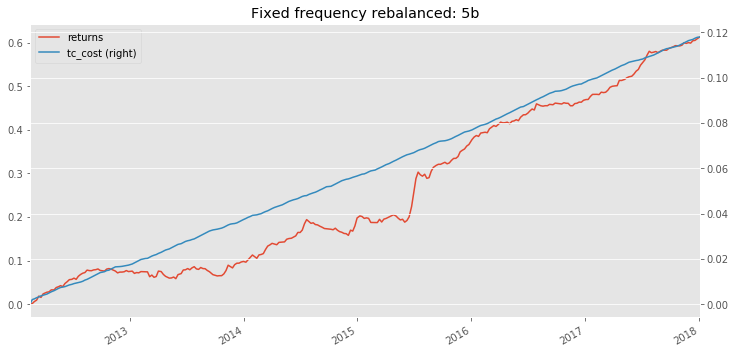

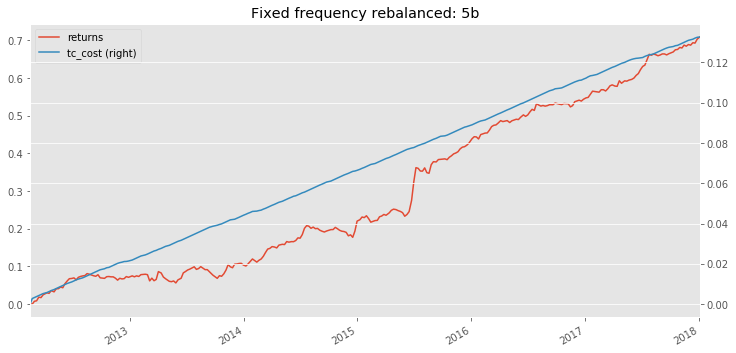

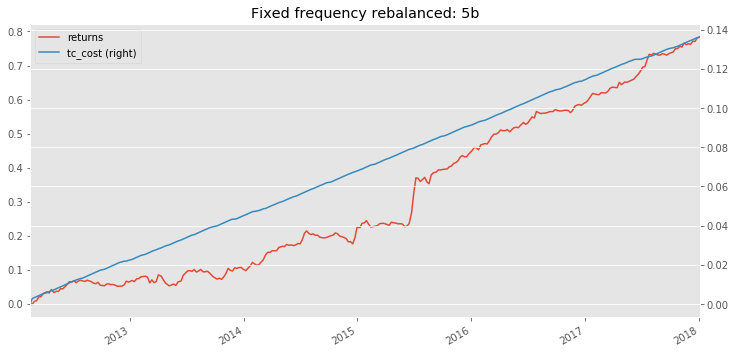

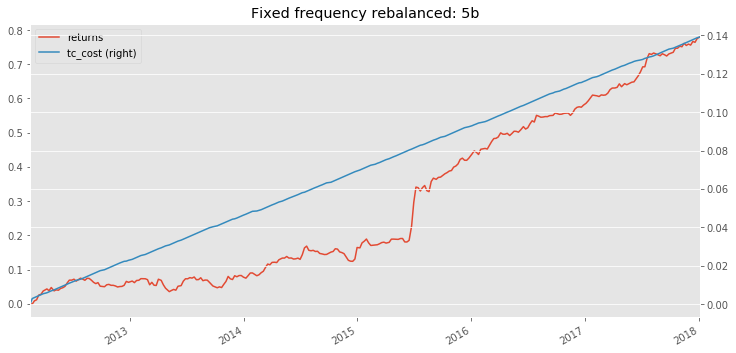

In [13]:
"""
Predicting and re-balance phase
"""
weight_gaps = [0.01, 0.02, 0.03, 0.04]
model1_weight = 1.0
model2_weight = 0.5

factor_groups = const_model_factor_data.groupby('trade_date')

for weight_gap in weight_gaps:
    print("start {0} weight gap simulation ...".format(weight_gap))

    rets = []
    turn_overs = []
    leverages = []
    previous_pos = pd.DataFrame()

    index_dates = []

    for i, value in enumerate(factor_groups):
        date = value[0]
        data = value[1]
        ref_date = date.strftime('%Y-%m-%d')

        total_data = data.fillna(data[total_features_keys].median())
        alpha_logger.info('{0}: {1}'.format(date, len(total_data)))
        risk_exp = total_data[neutralize_risk].values.astype(float)
        industry = total_data.industry_code.values
        benchmark_w = total_data.weight.values

        constraint_exp = total_data[constraint_risk].values
        risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)

        risk_names = constraint_risk + ['total']
        risk_target = risk_exp_expand.T @ benchmark_w

        lbound = np.maximum(0., benchmark_w - weight_gap)  # np.zeros(len(total_data))
        ubound = weight_gap + benchmark_w

        is_in_benchmark = (benchmark_w > 0.).astype(float)

        risk_exp_expand = np.concatenate((risk_exp_expand, is_in_benchmark.reshape((-1, 1))), axis=1).astype(float)
        risk_names.append('benchmark_total')

        constraint = Constraints(risk_exp_expand, risk_names)

        for i, name in enumerate(risk_names):
            if name == 'total':
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i],
                                           upper_bound=risk_target[i])
            elif name == 'SIZE':
                base_target = abs(risk_target[i])
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i] + base_target * size_risk_lower,
                                           upper_bound=risk_target[i] + base_target * size_risk_upper)
            elif name == 'benchmark_total':
                base_target = benchmark_w.sum()
                constraint.set_constraints(name,
                                           lower_bound=benchmark_total_lower * base_target,
                                           upper_bound=benchmark_total_upper * base_target)
            else:
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i] * industry_lower,
                                           upper_bound=risk_target[i] * industry_upper)
        
        factor_values = factor_processing(total_data[const_features_keys].values,
                                          pre_process=[winsorize_normal, standardize],
                                          risk_factors=risk_exp,
                                          post_process=[winsorize_normal, standardize])

        # const linear model
        er1 = const_model.predict(factor_values)

        # linear regression model
        try:
            model = models_series.ix[date]
        except KeyError:
            alpha_logger.info("model is not available. Omit this date")
            continue
            
        index_dates.append(date)

        # x = predict_x[date]
        x = predict_x[date]
        risk = predict_risk[date][:, 1:]
        this_predict_code = predict_code[date]
        
        new_x = cross_product(x, risk)
        er2 = model.predict(new_x)

        # combine model
        er1_table = pd.DataFrame({'er1': er1, 'code': total_data.code.values})
        er2_table = pd.DataFrame({'er2': er2, 'code': this_predict_code})
        er_table = pd.merge(er1_table, er2_table, on=['code'], how='left').fillna(0)

        er1 = er_table.er1.values
        er2 = er_table.er2.values
        
        if er2.std() > 0:
            print('using backbone model and alpha model')
            er = model1_weight * er1 / er1.std() +  model2_weight * er2 / er2.std()
        else:
            print('using only backbone modedl')
            er = model1_weight * er1

        codes = total_data['code'].values

        if previous_pos.empty:
            current_position = None
            turn_over_target = None
        else:
            previous_pos.set_index('code', inplace=True)
            remained_pos = previous_pos.loc[codes]

            remained_pos.fillna(0., inplace=True)
            turn_over_target = turn_over_target_base
            current_position = remained_pos.weight.values

        try:
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  use_rank=use_rank,
                                                  turn_over_target=turn_over_target,
                                                  current_position=current_position,
                                                  lbound=lbound,
                                                  ubound=ubound)
        except ValueError:
            alpha_logger.info('{0} full re-balance'.format(date))
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  use_rank=use_rank,
                                                  lbound=lbound,
                                                  ubound=ubound)

        target_pos['code'] = total_data['code'].values

        turn_over, executed_pos = executor.execute(target_pos=target_pos)

        executed_codes = executed_pos.code.tolist()
        dx_returns = engine.fetch_dx_return(date, executed_codes, horizon=horizon, offset=1)

        result = pd.merge(executed_pos, total_data[['code', 'weight']], on=['code'], how='inner')
        result = pd.merge(result, dx_returns, on=['code'])

        leverage = result.weight_x.abs().sum()

        ret = result.weight_x.values @ (np.exp(result.dx.values) - 1.)
        rets.append(np.log(1. + ret))
        executor.set_current(executed_pos)
        turn_overs.append(turn_over)
        leverages.append(leverage)

        previous_pos = executed_pos
        alpha_logger.info('{0} is finished'.format(date))

    ret_df = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverages}, index=index_dates)

    # index return
    index_return = engine.fetch_dx_return_index_range(benchmark_code, start_date, end_date, horizon=horizon,
                                                      offset=1).set_index('trade_date')
    ret_df['index'] = index_return['dx']

    ret_df.loc[advanceDateByCalendar('china.sse', ref_dates[-1], frequency)] = 0.
    ret_df = ret_df.shift(1)
    ret_df.iloc[0] = 0.
    ret_df['tc_cost'] = ret_df.turn_over * 0.002
    ret_df['returns'] = ret_df['leverage'] * (ret_df['returns'] - ret_df['index'])

    ret_df[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                                 title='Fixed frequency rebalanced: {0}'.format(frequency),
                                                 secondary_y='tc_cost')

    ret_df['ret_after_tc'] = ret_df['returns'] - ret_df['tc_cost']
    

    sharp_calc = MovingSharp(49)
    drawdown_calc = MovingMaxDrawdown(49)
    max_drawdown_calc = MovingMaxDrawdown(len(ret_df))

    res_df = pd.DataFrame(columns=['daily_return', 'cum_ret', 'sharp', 'drawdown', 'max_drawn', 'leverage'])

    total_returns = 0.

    for i, ret in enumerate(ret_df['ret_after_tc']):
        date = ret_df.index[i]
        total_returns += ret
        sharp_calc.push({'ret': ret, 'riskFree': 0.})
        drawdown_calc.push({'ret': ret})
        max_drawdown_calc.push({'ret': ret})

        res_df.loc[date, 'daily_return'] = ret
        res_df.loc[date, 'cum_ret'] = total_returns
        res_df.loc[date, 'drawdown'] = drawdown_calc.result()[0]
        res_df.loc[date, 'max_drawn'] = max_drawdown_calc.result()[0]
        res_df.loc[date, 'leverage'] = ret_df.loc[date, 'leverage']

        if i < 10:
            res_df.loc[date, 'sharp'] = 0.
        else:
            res_df.loc[date, 'sharp'] = sharp_calc.result() * np.sqrt(49)

    res_df.to_csv('hs300_{0}.csv'.format(int(weight_gap * 100)))

## combine
-------------

In [ ]:
from pandas import ExcelWriter
writer = ExcelWriter('d:/多因子500+300合并.xlsx')

df1 = pd.read_csv('d:/hs300.csv', index_col=0)
df2 = pd.read_csv('d:/zz500.csv', index_col=0)

In [51]:
weights_secnario = {
    '3-1': (3., 1.),
    '2-1': (2., 1.),
    '1-1': (1., 1.),
}

In [52]:
for key, weights in weights_secnario.items():
    weight300, weight500 = weights
    ret_series = (weight300* df1['ret_after_tc'] + weight500 * df2['ret_after_tc']) /  (weight300 + weight500)

    sharp_calc = MovingSharp(49)
    drawdown_calc = MovingMaxDrawdown(49)
    max_drawdown_calc = MovingMaxDrawdown(len(ret_df))

    res_df = pd.DataFrame(columns=['daily_return', 'cum_ret', 'sharp', 'drawdown', 'max_drawn'])

    total_returns = 0.

    for i, ret in enumerate(ret_series):
        date = ret_series.index[i]
        sharp_calc.push({'ret': ret, 'riskFree': 0.})
        drawdown_calc.push({'ret': ret})
        max_drawdown_calc.push({'ret': ret})
        total_returns += ret
        res_df.loc[date, 'daily_return'] = ret
        res_df.loc[date, 'cum_ret'] = total_returns
        res_df.loc[date, 'drawdown'] = drawdown_calc.result()[0]
        res_df.loc[date, 'max_drawn'] = max_drawdown_calc.result()[0]

        if i < 10:
            res_df.loc[date, 'sharp'] = 0.
        else:
            res_df.loc[date, 'sharp'] = sharp_calc.result() * np.sqrt(49)
            
        res_df.to_excel(writer, key)

In [53]:
writer.save()